In [1]:
import gc
import os
import random
import re
import statistics as st
import warnings
from collections import Counter

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from scipy.stats import kurtosis, skew
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.autonotebook import tqdm

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config:
    INPUT_DIR = "./data"
    seed = 42
    is_time_in_secs = True
    time_divider = 1000 if is_time_in_secs else 1

    num_folds = 5
    num_estimators = 10000
    num_trials_early_stopping = 100

    response_variate = "score"
    use_optuna_tuning = True
    test_size_optuna = 0.3
    num_trials_optuna = 150

    num_features_to_display = 50

In [3]:
cnfg = Config()

In [4]:
tqdm.pandas()
sns.set_style("whitegrid")
warnings.simplefilter("ignore")
random.seed(cnfg.seed)

In [5]:
train_logs = pd.read_csv(f"{cnfg.INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{cnfg.INPUT_DIR}/train_scores.csv")
test_logs = pd.read_csv(f"{cnfg.INPUT_DIR}/test_logs.csv")

In [6]:
train_logs.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count'],
      dtype='object')

### Utils ###

In [7]:
def my_max(lst):
    try:
        x = max(lst)
    except:
        x = 0
    return x


def my_min(lst):
    try:
        x = min(lst)
    except:
        x = 0
    return x


def my_mean(lst):
    try:
        x = np.mean(lst)
    except:
        x = 0
    return x


def my_std(lst):
    try:
        x = st.stdev(lst)
    except:
        x = 0
    return x


def my_skew(lst):
    try:
        x = skew(lst)
    except:
        x = 0
    return x


def my_kurtosis(lst):
    try:
        x = kurtosis(lst)
    except:
        x = 0
    return x


def my_median_grouped(lst):
    try:
        x = st.median_grouped(lst)
    except:
        x = 0
    return x


def my_sum(lst):
    try:
        x = sum(lst)
    except:
        x = 0
    return x

### Pre-processing ###

In [24]:
class Preprocessor:
    def __init__(self, seed, df):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.activities_name_mapping = {
            "Input": "input",
            "Remove/Cut": "remove",
            "Nonproduction": "non_production",
            "Replace": "replace",
            "Paste": "paste",
        }
        self.text_changes = text_changes = [
            "q",
            " ",
            # "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.special_character_name_mapping = special_character_name_mapping = {
            "'": "qoute",
            '"': "double_qoute",
            ".": "full_stop",
            ",": "comma",
            "-": "hyphen",
            "?": "question_mark",
            ";": "semi_colon",
            "=": "equal_to",
            "/": "forward_slash",
            "\\": "back_slash",
            ":": "colon",
            "(": "bracket_open",
            ")": "bracket_close",
            "!": "exclamation_mark",
            "[": "square_bracket_open",
            "$": "dollar",
            ">": "greater_than_sign",
            "]": "square_bracket_close",
            "*": "star",
            "%": "percentage",
            "&": "ampresand",
            "<": "less_than_sign",
            "+": "plus_sign",
            "_": "under_score",
            "{": "curly_bracket_open",
            "`": "tilted_qoute",
            "#": "hashtag",
            " ": "blank_space",
            "\n": "new_line_char",
        }
        self.df = df.sort_values(["id", "event_id"]).reset_index(drop=True)

    def remove_lower_categorical_values(self):
        ## Clean activity
        self.df["activity"] = self.df.activity.apply(
            lambda x: x if x in self.activities else "__OUTLIER__"
        )

    def clean_up_time(self):
        """
        For maximum number of ids uptime is not increasing. In each id for one or two events, up_time is incorrectly recorded
        Procedure: Calculate the difference with next if diff is negative replace up_time with the up_time of next.
        """
        print(f"Before uptime cleaning, data shape: {self.df.shape}")
        tmp_df = self.df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        # Do it once more
        tmp_df = tmp_df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        self.df["up_time"] = tmp_df["up_time"]
        print(f"After uptime cleaning, data shape: {self.df.shape}")

    def add_latency_columns(self):
        # HL -> Hold latency, up_time-down_time
        # IL-> Interkey latency -> down_time(event2) - up_time(event1)
        # PL -> Press latency -> down_time(event2)- down_time(event1) or HL+IL
        # RL -> Release Latency -> up_time(event2)- up_time(event1)
        # self.df["HL"] = self.df["up_time"] - self.df["down_time"] #same as action_time
        self.df["IL"] = self.df["up_time"] - self.df.groupby("id").down_time.shift(1)
        self.df["IL"] = self.df["IL"].fillna(0)
        self.df["PL"] = self.df["down_time"] - self.df.groupby("id").down_time.shift(1)
        self.df["PL"] = self.df["PL"].fillna(0)
        self.df["RL"] = self.df["up_time"] - self.df.groupby("id").up_time.shift(1)
        self.df["RL"] = self.df["RL"].fillna(0)

        # self.df = self.df[~self.df.isna().any(axis=1)].reset_index(drop=True)

    def clean_data(self):
        self.remove_lower_categorical_values()
        self.clean_up_time()

        self.add_latency_columns()

    def change_time_columns_to_secs(self):
        time_columns = ["down_time", "up_time", "action_time", "IL", "PL", "RL"]
        for clm in time_columns:
            self.df[clm] = self.df[clm] / cnfg.time_divider

    def activity_features(self, tmp_df):
        # Activity Counts to total activity count ratio
        # Number of different activities
        features_to_drop = []
        ret = list()
        for i, li in tqdm(enumerate(tmp_df["activity_list"].values)):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities_name_mapping.keys():
                di[self.activities_name_mapping[k]] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in self.activities_name_mapping.keys():
                    # if self.activities_name_mapping[k] in di:
                    di[self.activities_name_mapping[k]] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{act_name}_count" for act_name in ret.columns]
        ret.columns = cols

        # If using ratios drop count columns
        features_to_drop.extend(cols)

        tmp_df = pd.concat([tmp_df, ret], axis=1)
        ###############################################################################
        # Ratios to total activity
        for act_clm in self.activities_name_mapping.values():
            tmp_df[f"activity_{act_clm}_ratio_total"] = (
                tmp_df[f"activity_{act_clm}_count"] / tmp_df["total_num_activites"]
            )
        ###############################################################################
        # Ratio to "Input" Activity
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "input":
                tmp_df[f"activity_{act_clm}_ratio_input"] = (
                    tmp_df[f"activity_{act_clm}_count"] / tmp_df["activity_input_count"]
                )
        ###############################################################################
        # Ratio to "Nonproduction"
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "non_production":
                tmp_df[f"activity_{act_clm}_ratio_non_production"] = (
                    tmp_df[f"activity_{act_clm}_count"]
                    / tmp_df["activity_non_production_count"]
                )
        ###############################################################################
        # Ratio of first occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            first_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="first"
            )
            first_occr_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ] = first_occr_df["down_time"]
            first_occr_df = first_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_first_time"]
            ]
            tmp_df = tmp_df.merge(first_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                - tmp_df["start_time"]
            )
            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ].fillna(
                -1
            )

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_first_time"
            )
        ###############################################################################
        # Ratio of last occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            last_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="last"
            )
            last_occr_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ] = last_occr_df["down_time"]
            last_occr_df = last_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_last_time"]
            ]
            tmp_df = tmp_df.merge(last_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                - tmp_df["start_time"]
            )
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ].fillna(
                -1
            )

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_last_time"
            )

        ###############################################################################
        # min max mean std and other stats values of time between each type of activity
        methods_to_apply = [
            my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            my_kurtosis,
            my_median_grouped,
        ]

        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            particular_act_df[f"{act_clm}_prev_event_time"] = particular_act_df.groupby(
                "id"
            ).down_time.shift(1)
            particular_act_df[f"{act_clm}_inter_act_latency"] = (
                particular_act_df["down_time"]
                - particular_act_df[f"{act_clm}_prev_event_time"]
            )

            particular_act_df[f"{act_clm}_inter_act_latency"] = particular_act_df[
                f"{act_clm}_inter_act_latency"
            ].fillna(0)

            # particular_act_df = particular_act_df[
            #     ~particular_act_df.isna().any(axis=1)
            # ].reset_index(drop=True)

            colname = f"{act_clm}_inter_act_latency"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{act_clm}_{method_name}_inter_act_latency"
                tmp2_df = (
                    particular_act_df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        ###############################################################################
        # Number of type of down_events in each of ["Input", "Remove/Cut", "Nonproduction"]
        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            colname = f"num_type_down_events_in_{act_clm}"
            tmp2_df = (
                particular_act_df.groupby("id", as_index=False)
                .agg({"down_event": "nunique"})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        ###############################################################################
        ## Ways in which remove/cut happens -> Top ways -> ['Backspace','Delete','x','z','Rightclick'] ratios
        remove_df = self.df[self.df.activity == "Remove/Cut"].reset_index(drop=True)
        name_for_remove = self.activities_name_mapping["Remove/Cut"]
        remove_feats_df = remove_df.groupby("id", as_index=False).agg(
            total_remove_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(remove_feats_df, on="id", how="left")

        features_to_drop.append("total_remove_activity")  # Remove this column

        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp2_df = (
                remove_df[remove_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_remove_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which replace happens -> Top ways -> ['q','Space','.',',','z','v','Enter','Rightclick'] ratios
        replace_df = self.df[self.df.activity == "Replace"].reset_index(drop=True)
        name_for_replace = self.activities_name_mapping["Replace"]
        replace_feats_df = replace_df.groupby("id", as_index=False).agg(
            total_replace_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(replace_feats_df, on="id", how="left")

        features_to_drop.append("total_replace_activity")  # Remove this column

        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp2_df = (
                replace_df[replace_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_replace_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Nonproduction happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_np = [
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            "ArrowDown",
            "ArrowUp",
            "CapsLock",
            "Control",
            "Backspace",
            "Tab",
            "ContextMenu",
            "End",
            "Rightclick",
        ]
        np_df = self.df[self.df.activity == "Nonproduction"].reset_index(drop=True)
        name_for_np = self.activities_name_mapping["Nonproduction"]
        np_feats_df = np_df.groupby("id", as_index=False).agg(
            total_np_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(np_feats_df, on="id", how="left")

        features_to_drop.append("total_np_activity")  # Remove this column

        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp2_df = (
                np_df[np_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_np_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Input happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_input = [
            "q",
            "Space",
            "Enter",
        ] + list(self.special_character_name_mapping.keys())

        top_ways_input = [
            inp
            for inp in top_ways_input
            if inp
            not in [
                ":",
                "(",
                ")",
                "!",
                "[",
                "$",
                ">",
                "]",
                "*",
                "%",
                "&",
                "<",
                "+",
                "_",
                "{",
                "`",
                "#",
                " ",
                "\n",
            ]
        ]
        input_df = self.df[self.df.activity == "Input"].reset_index(drop=True)
        name_for_input = self.activities_name_mapping["Input"]
        input_feats_df = input_df.groupby("id", as_index=False).agg(
            total_input_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(input_feats_df, on="id", how="left")

        features_to_drop.append("total_input_activity")  # Remove this column

        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp2_df = (
                input_df[input_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_input_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################

        ###############################################################################
        print(f"Features dropping in activity function {features_to_drop}")
        tmp_df = tmp_df.drop(columns=features_to_drop)
        return tmp_df

    def word_count_features(self, tmp_df):
        word_count_df = self.df[["id", "event_id", "word_count", "down_time"]]
        # Number of times words deleted:
        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count"
        ] - word_count_df.groupby("id").word_count.shift(1)

        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count_first_derivative"
        ].fillna(0)
        # word_count_df = word_count_df[~word_count_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df.groupby("id", as_index=False).agg(
            num_times_word_deleted=(
                "word_count_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            num_words_deleted=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_sum([-i for i in list(x) if i < 0]),
            ),
            size_of_biggest_chunk_removed=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_num_words_removed_at_a_time=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["num_words_deleted"] = (
            tmp_df["num_words_deleted"] / tmp_df["total_word_count"]
        )
        tmp_df["num_words_deleted"] = tmp_df["num_words_deleted"].fillna(0)

        tmp_df["size_of_biggest_chunk_removed"] = (
            tmp_df["size_of_biggest_chunk_removed"] / tmp_df["total_word_count"]
        )
        tmp_df["size_of_biggest_chunk_removed"] = tmp_df[
            "size_of_biggest_chunk_removed"
        ].fillna(0)

        tmp_df["avg_num_words_removed_at_a_time"] = (
            tmp_df["avg_num_words_removed_at_a_time"] / tmp_df["total_word_count"]
        )
        tmp_df["avg_num_words_removed_at_a_time"] = tmp_df[
            "avg_num_words_removed_at_a_time"
        ].fillna(0)

        word_count_df2 = word_count_df[
            word_count_df.word_count_first_derivative < 0
        ].reset_index(drop=True)
        word_count_df2 = word_count_df2.merge(
            tmp_df[["id", "start_time", "total_time_taken"]], on="id"
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["down_time"] - word_count_df2["start_time"]
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["time_for_word_deletion_share"]
            / word_count_df2["total_time_taken"]
        )

        # Time after start when word is deleted first time and last time
        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            first_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[0],
            ),
            last_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[-1],
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["first_time_word_deletion"] = tmp_df["first_time_word_deletion"].fillna(
            0
        )
        tmp_df["last_time_word_deletion"] = tmp_df["last_time_word_deletion"].fillna(0)

        # Average,max,min,std of time between word deletions
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "down_time"
        ] - word_count_df2.groupby("id").down_time.shift(1)
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "time_between_word_deletions"
        ].fillna(0)
        # word_count_df2 = word_count_df2[~word_count_df2.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            mean_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_mean(list(x)),
            ),
            max_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_max(list(x)),
            ),
            min_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_min(list(x)),
            ),
            std_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_std(list(x)),
            ),
        )

        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["mean_time_btw_word_deletions"] = (
            tmp_df["mean_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["mean_time_btw_word_deletions"] = tmp_df[
            "mean_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["max_time_btw_word_deletions"] = (
            tmp_df["max_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["max_time_btw_word_deletions"] = tmp_df[
            "max_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["min_time_btw_word_deletions"] = (
            tmp_df["min_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["min_time_btw_word_deletions"] = tmp_df[
            "min_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["std_time_btw_word_deletions"] = (
            tmp_df["std_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["std_time_btw_word_deletions"] = tmp_df[
            "std_time_btw_word_deletions"
        ].fillna(0)

        return tmp_df

    def cursor_position_features(self, tmp_df):
        cursor_pos_df = self.df[["id", "event_id", "cursor_position", "down_time"]]
        # Number of times cursor position is decreased means gone back to see something:
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_position"
        ] - cursor_pos_df.groupby("id").cursor_position.shift(1)
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_pos_first_derivative"
        ].fillna(0)
        # cursor_pos_df = cursor_pos_df[~cursor_pos_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        cp_feats_df = cursor_pos_df.groupby("id", as_index=False).agg(
            num_times_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            size_of_biggest_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_size_of_cp_decreased_at_a_time=(
                "cursor_pos_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        cp_feats_df = cp_feats_df.fillna(0)
        tmp_df = tmp_df.merge(cp_feats_df, on="id", how="left")

        return tmp_df

    def text_change_features(self, tmp_df):
        # Count of all text_change features
        for txt_chng in self.text_changes:
            txt_chng_name = (
                txt_chng
                if txt_chng not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[txt_chng]
            )

            text_change_df = self.df[self.df.text_change == txt_chng]
            cnt_col_name = f"{txt_chng_name}_tc_total_share"
            text_change_features = (
                text_change_df.groupby("id", as_index=False)
                .agg({"text_change": lambda x: len(list(x))})
                .rename(columns={"text_change": cnt_col_name})
            )
            tmp_df = tmp_df.merge(text_change_features, on="id", how="left")
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)
            ## Ratio of text_change in particular activity
            for act in ["Input", "Remove/Cut"]:
                act_name = self.activities_name_mapping[act]
                cnt_col_name2 = f"{txt_chng_name}_in_{act_name}_tc_total_share"
                text_change_df2 = text_change_df[text_change_df.activity == act]
                text_change_features2 = (
                    text_change_df2.groupby("id", as_index=False)
                    .agg({"text_change": lambda x: len(list(x))})
                    .rename(columns={"text_change": cnt_col_name2})
                )

                tmp_df = tmp_df.merge(text_change_features2, on="id", how="left")
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)
                # Normalise
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2] / tmp_df[cnt_col_name]
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)

            # Normalise count of text change type with total event count
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name] / tmp_df["num_events"]
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)

        return tmp_df

    def word_len_features(self, tmp_df):
        essay_text_df = self.df[
            (~self.df["text_change"].str.contains("=>"))
            & (self.df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        essay_text_df = (
            essay_text_df.groupby("id").agg({"text_change": list}).reset_index()
        )
        essay_text_df["text_change"] = essay_text_df["text_change"].apply(
            lambda x: "".join(x)
        )
        essay_text_df["text_change2"] = essay_text_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        essay_text_df["input_word_count"] = essay_text_df["text_change2"].apply(len)
        essay_text_df["input_word_length_mean"] = essay_text_df["text_change2"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_max"] = essay_text_df["text_change2"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_std"] = essay_text_df["text_change2"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_skew"] = essay_text_df["text_change2"].apply(
            lambda x: my_skew([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_kurtosis"] = essay_text_df[
            "text_change2"
        ].apply(lambda x: my_kurtosis([len(i) for i in x] if len(x) > 0 else 0))

        essay_text_df2 = essay_text_df[["id", "text_change2"]].explode(
            column="text_change2"
        )
        essay_text_df2 = essay_text_df2.dropna().reset_index(drop=True)

        essay_text_df = essay_text_df.drop(columns=["text_change", "text_change2"])

        tmp_df = tmp_df.merge(essay_text_df, on="id", how="left")

        ## Count number of words of lengths ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'more_than_10']
        essay_text_df2["word_len"] = essay_text_df2.text_change2.apply(
            lambda x: "more_than_10" if len(x) > 10 else str(len(x))
        )

        essay_text_df2 = essay_text_df2.groupby("id", as_index=False).agg(
            {"word_len": list}
        )
        list_of_word_lens = [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "more_than_10",
        ]
        ret = list()
        for li in tqdm(essay_text_df2["word_len"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in list_of_word_lens:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"words_of_len_{i}_share" for i in ret.columns]
        ret.columns = cols
        tmp_df = pd.concat([tmp_df, ret], axis=1)
        # Normalise
        for word_len in list_of_word_lens:
            colname = f"words_of_len_{word_len}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["input_word_count"]

        return tmp_df

    def get_stats_for_different_latency(self, tmp_df):
        methods_to_apply = [
            # my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            my_kurtosis,
            my_median_grouped,
        ]
        clms_for_stats = ["action_time", "IL", "PL"]

        for clm in clms_for_stats:
            colname = f"{clm}_stats"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{colname}_{method_name}"
                tmp2_df = (
                    self.df.groupby(["id"])
                    .agg({clm: method})
                    .reset_index()
                    .rename(columns={clm: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        return tmp_df

    def feature_engineering(self):
        # initialize features dataframe
        # feats = pd.DataFrame({"id": self.df["id"].unique().tolist()})

        feats = self.df.groupby("id", as_index=False).agg(
            total_time_taken=("down_time", lambda x: list(x)[-1] - list(x)[0]),
            total_idle_time=("IL", lambda x: sum(x)),
            total_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0]),
            max_cursor_position=("cursor_position", lambda x: my_max(list(x))),
            num_events=("event_id", lambda x: len(list(x))),
            activity_list=("activity", list),
            total_num_activites=("activity", lambda x: len(list(x))),
            total_type_of_activities=("activity", lambda x: len(set(x))),
            start_time=("down_time", lambda x: list(x)[0]),
            end_time=("down_time", lambda x: list(x)[-1]),
        )

        features_to_drop = [
            "activity_list",
            "total_num_activites",
            "start_time",
            "end_time",
        ]

        # events to time ratio or rate of event or speed of activity
        feats["speed_of_activity"] = feats["num_events"] / feats["total_time_taken"]
        feats["speed_of_writing"] = (
            feats["total_word_count"] / feats["total_time_taken"]
        )
        feats["events_per_word"] = feats["total_word_count"] / feats["num_events"]
        feats["idle_time_ratio"] = feats["total_idle_time"] / feats["total_time_taken"]

        feats["words_to_cp_ratio"] = (
            feats["total_word_count"] / feats["max_cursor_position"]
        )  # indicator of words per line

        # After Activity features
        print("-" * 25)
        print("Starting Activity Features")
        feats = self.activity_features(feats)

        # Word count features
        print("-" * 25)
        print("Starting Word Count Features")
        feats = self.word_count_features(feats)

        # Cursor position features
        print("-" * 25)
        print("Starting Cursor Position Features")
        feats = self.cursor_position_features(feats)

        # IL, PL, action_time statistical features
        print("-" * 25)
        print("Starting Stats Features")
        feats = self.get_stats_for_different_latency(feats)

        print("-" * 25)
        print("Starting Text Change Features")
        feats = self.text_change_features(feats)

        print("-" * 25)
        print("Starting Word Length Features")
        feats = self.word_len_features(feats)

        feats = feats.drop(columns=features_to_drop)
        return feats

    def pre_process_data(self):
        self.clean_data()

        if cnfg.is_time_in_secs:
            self.change_time_columns_to_secs()

        return self.df

    def pre_process_and_engineer_features(self):
        _ = self.pre_process_data()
        features_df = self.feature_engineering()

        return self.df, features_df

In [25]:
preprocess_train = Preprocessor(cnfg.seed, train_logs)
train_logs2, train_feats = preprocess_train.pre_process_and_engineer_features()

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
preprocess_test = Preprocessor(cnfg.seed, test_logs)
_, test_feats = preprocess_test.pre_process_and_engineer_features()

Before uptime cleaning, data shape: (8405898, 11)
After uptime cleaning, data shape: (8405898, 11)
-------------------------
Starting Activity Features


2471it [00:00, 11955.87it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 32137.72it/s]



-------------------------
Engineering features for test data
-------------------------
Before uptime cleaning, data shape: (6, 11)
After uptime cleaning, data shape: (6, 11)
-------------------------
Starting Activity Features


3it [00:00, 60787.01it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]


In [26]:
train_logs2

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,IL,PL,RL
0,001519c8,1,4.526,4.557,0.031,Nonproduction,Leftclick,Leftclick,NoChange,0,0,0.000,0.000,0.000
1,001519c8,2,4.558,4.962,0.404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,0.436,0.032,0.405
2,001519c8,3,106.571,106.571,0.000,Nonproduction,Shift,Shift,NoChange,0,0,102.013,102.013,101.609
3,001519c8,4,106.686,106.777,0.091,Input,q,q,q,1,1,0.206,0.115,0.206
4,001519c8,5,107.196,107.323,0.127,Input,q,q,q,2,1,0.637,0.510,0.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063.944,2064.440,0.496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240,2.023,1.527,1.885
8405894,fff05981,3616,2064.497,2064.497,0.000,Nonproduction,Shift,Shift,NoChange,1031,240,0.553,0.553,0.057
8405895,fff05981,3617,2064.657,2064.765,0.108,Replace,q,q,q => q,1031,240,0.268,0.160,0.268
8405896,fff05981,3618,2069.186,2069.259,0.073,Nonproduction,Leftclick,Leftclick,NoChange,1028,240,4.602,4.529,4.494


In [27]:
train_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [28]:
# tmp = train_logs2.groupby(["id"]).agg({'PL': my_std}).reset_index().rename(columns={'PL': 'min_PL'})

In [29]:
# tmp.min_PL.describe()

In [30]:
train_feats.head()

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,words_of_len_2_share,words_of_len_3_share,words_of_len_4_share,words_of_len_5_share,words_of_len_6_share,words_of_len_7_share,words_of_len_8_share,words_of_len_9_share,words_of_len_10_share,words_of_len_more_than_10_share
0,001519c8,1797.351,2094.432,255,1539,2557,5,1.422649,0.141875,0.099726,...,0.207650,0.147541,0.133880,0.117486,0.079235,0.081967,0.040984,0.057377,0.027322,0.084699
1,0022f953,1758.219,2033.053,320,1676,2454,5,1.395731,0.182002,0.130399,...,0.184416,0.254545,0.179221,0.116883,0.096104,0.033766,0.020779,0.015584,0.015584,0.044156
2,0042269b,1766.778,2186.390,404,2291,4136,4,2.340985,0.228665,0.097679,...,0.156300,0.173844,0.162679,0.111643,0.076555,0.086124,0.054226,0.049442,0.020734,0.092504
3,0059420b,1362.999,1552.444,206,1047,1556,5,1.141600,0.151137,0.132391,...,0.203187,0.147410,0.199203,0.107570,0.095618,0.099602,0.015936,0.015936,0.011952,0.051793
4,0075873a,1583.920,1897.356,252,1402,2531,3,1.597934,0.159099,0.099565,...,0.167476,0.182039,0.174757,0.114078,0.080097,0.038835,0.048544,0.038835,0.031553,0.060680


In [31]:
# train_logs2['IL']

In [32]:
train_feats.IL_stats_my_median_grouped.describe()

count    2471.000000
mean        0.259707
std         0.297508
min        -0.388464
25%         0.015487
50%         0.262545
75%         0.510476
max         0.970000
Name: IL_stats_my_median_grouped, dtype: float64

In [33]:
train_feats[train_feats.isna().any(axis=1)]

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,words_of_len_2_share,words_of_len_3_share,words_of_len_4_share,words_of_len_5_share,words_of_len_6_share,words_of_len_7_share,words_of_len_8_share,words_of_len_9_share,words_of_len_10_share,words_of_len_more_than_10_share
1809,be2130ad,1725.407,2020.685,398,2118,2477,4,1.435603,0.23067,0.160678,...,0.21831,0.183099,0.178404,0.133803,0.100939,0.046948,0.049296,0.00939,0.014085,0.007042


In [34]:
test_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [35]:
test_feats

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,words_of_len_2_share,words_of_len_3_share,words_of_len_4_share,words_of_len_5_share,words_of_len_6_share,words_of_len_7_share,words_of_len_8_share,words_of_len_9_share,words_of_len_10_share,words_of_len_more_than_10_share
0,0000aaaa,421.640,421.727,0,1,2,1,0.004743,0.00000,0.0,...,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2222bbbb,-421.454,-421.408,0,1,2,1,-0.004745,-0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4444cccc,-450.551,-450.495,1,1,2,1,-0.004439,-0.00222,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# clms_with_na = features_df.columns[features_df.isnull().any()].tolist()

In [37]:
# for clm in clms_with_na:
#     # print(f"{clm}\n")
#     print(features_df[f"{clm}"].isna().value_counts())
#     print("\n")

In [38]:
train_feats.columns.tolist()

['id',
 'total_time_taken',
 'total_idle_time',
 'total_word_count',
 'max_cursor_position',
 'num_events',
 'total_type_of_activities',
 'speed_of_activity',
 'speed_of_writing',
 'events_per_word',
 'idle_time_ratio',
 'words_to_cp_ratio',
 'activity_input_ratio_total',
 'activity_remove_ratio_total',
 'activity_non_production_ratio_total',
 'activity_replace_ratio_total',
 'activity_paste_ratio_total',
 'activity_remove_ratio_input',
 'activity_non_production_ratio_input',
 'activity_replace_ratio_input',
 'activity_paste_ratio_input',
 'activity_input_ratio_non_production',
 'activity_remove_ratio_non_production',
 'activity_replace_ratio_non_production',
 'activity_paste_ratio_non_production',
 'input_first_time_total_ratio',
 'remove_first_time_total_ratio',
 'non_production_first_time_total_ratio',
 'replace_first_time_total_ratio',
 'paste_first_time_total_ratio',
 'input_last_time_total_ratio',
 'remove_last_time_total_ratio',
 'non_production_last_time_total_ratio',
 'replace

In [39]:
train_feats.equal_to_in_input_tc_total_share.describe()

count    2471.000000
mean        0.109753
std         0.207478
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: equal_to_in_input_tc_total_share, dtype: float64

In [40]:
# features_df.square_bracket_open_in_input_share.value_counts()

In [41]:
train_feats = train_feats.merge(train_scores, on="id", how="left")

In [42]:
print(f"Shape of training data: {train_feats.shape}")
print(f"Shape of test data: {test_feats.shape}")

Shape of training data: (2471, 189)
Shape of test data: (3, 188)


In [43]:
train_feats.columns[train_feats.isna().any()]

Index(['remove_my_min_inter_act_latency', 'remove_my_max_inter_act_latency',
       'remove_my_mean_inter_act_latency', 'remove_my_std_inter_act_latency',
       'remove_my_skew_inter_act_latency',
       'remove_my_kurtosis_inter_act_latency',
       'remove_my_median_grouped_inter_act_latency',
       'num_type_down_events_in_remove'],
      dtype='object')

# Split Train Data Into Folds For Cross-Validation

In [44]:
# kfold = KFold(n_splits=CONFIG.num_folds, shuffle=True, random_state=CONFIG.seed)

kfold = StratifiedKFold(n_splits=cnfg.num_folds, shuffle=True, random_state=cnfg.seed)
for fold, (_, val_idx) in enumerate(
    kfold.split(train_feats, train_feats.score.apply(str).values)
):
    train_feats.loc[val_idx, "fold"] = fold

# Optimizing Hyperparameters with Optuna

In [45]:
def objective(trial, train_feats):
    train_feats_df = train_feats.copy()
    print(trial.number)
    param = {
        "metric": "rmse",
        "random_state": cnfg.seed,
        "n_estimators": cnfg.num_estimators,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "verbose": -1,
        "early_stopping_rounds": cnfg.num_trials_early_stopping,
    }

    feature_names = list(
        filter(
            lambda x: x not in [cnfg.response_variate, "id", "fold"],
            train_feats_df.columns,
        )
    )

    # models_dict = {}

    for fold in range(cnfg.num_folds):
        # print(f"Training for FOLD {fold}")

        X_train = train_feats_df[train_feats_df["fold"] != fold][feature_names]
        Y_train = train_feats_df[train_feats_df["fold"] != fold][cnfg.response_variate]

        X_val = train_feats_df[train_feats_df["fold"] == fold][feature_names]
        Y_val = train_feats_df[train_feats_df["fold"] == fold][cnfg.response_variate]

        model = lgb.LGBMRegressor(**param)

        model.fit(
            X_train,
            Y_train,
            eval_names=["train", "valid"],
            eval_set=[(X_train, Y_train), (X_val, Y_val)],
            # verbose=-1,
            eval_metric="rmse",
            # early_stopping_rounds=cnfg.num_trials_early_stopping,
        )

        # models_dict[fold] = model

        pred_val = model.predict(X_val, num_iteration=model.best_iteration_)
        train_feats_df.loc[X_val.index, f"pred_{cnfg.response_variate}"] = pred_val

    rmse = mean_squared_error(
        train_feats_df[cnfg.response_variate],
        np.clip(train_feats_df[f"pred_{cnfg.response_variate}"], a_min=0.5, a_max=6.0),
        squared=False,
    )

    return rmse

In [46]:
if cnfg.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(
        lambda trial: objective(trial, train_feats), n_trials=cnfg.num_trials_optuna
    )

[I 2023-10-30 21:24:14,257] A new study created in memory with name: Optimize boosting hyperparameters


0


[I 2023-10-30 21:24:15,685] Trial 0 finished with value: 0.6396295216710729 and parameters: {'reg_alpha': 6.6436079964388615, 'reg_lambda': 7.127758276543727, 'colsample_bytree': 0.9653130195642055, 'subsample': 0.6502982098569241, 'learning_rate': 0.03023235416315053, 'num_leaves': 7, 'min_child_samples': 95}. Best is trial 0 with value: 0.6396295216710729.


1


[I 2023-10-30 21:24:35,730] Trial 1 finished with value: 0.6385450724631199 and parameters: {'reg_alpha': 7.3180647535021714, 'reg_lambda': 0.00424347654377821, 'colsample_bytree': 0.7902868431507555, 'subsample': 0.5790993618172582, 'learning_rate': 0.0017168751659475724, 'num_leaves': 21, 'min_child_samples': 44}. Best is trial 1 with value: 0.6385450724631199.


2


[I 2023-10-30 21:24:37,743] Trial 2 finished with value: 0.6372729510207328 and parameters: {'reg_alpha': 0.13541889017733147, 'reg_lambda': 0.005619701361508654, 'colsample_bytree': 0.9362409531145626, 'subsample': 0.9070526173004114, 'learning_rate': 0.01672915675441392, 'num_leaves': 6, 'min_child_samples': 52}. Best is trial 2 with value: 0.6372729510207328.


3


[I 2023-10-30 21:24:38,882] Trial 3 finished with value: 0.6361266863151808 and parameters: {'reg_alpha': 1.2100544284543877, 'reg_lambda': 0.0028826173042353796, 'colsample_bytree': 0.6595563998361779, 'subsample': 0.6825264032502263, 'learning_rate': 0.052943605188307756, 'num_leaves': 28, 'min_child_samples': 98}. Best is trial 3 with value: 0.6361266863151808.


4


[I 2023-10-30 21:25:24,421] Trial 4 finished with value: 0.6361326320056375 and parameters: {'reg_alpha': 0.004776520730537683, 'reg_lambda': 0.0013745894412467347, 'colsample_bytree': 0.6683430789704488, 'subsample': 0.6198972158107499, 'learning_rate': 0.0005767346650149196, 'num_leaves': 17, 'min_child_samples': 58}. Best is trial 3 with value: 0.6361266863151808.


5


[I 2023-10-30 21:26:18,280] Trial 5 finished with value: 0.6365862547897322 and parameters: {'reg_alpha': 0.0025259573976618515, 'reg_lambda': 0.013618229600831163, 'colsample_bytree': 0.6775941207114886, 'subsample': 0.688786345113834, 'learning_rate': 0.0008611417255486777, 'num_leaves': 26, 'min_child_samples': 7}. Best is trial 3 with value: 0.6361266863151808.


6


[I 2023-10-30 21:27:23,738] Trial 6 finished with value: 0.6472418727406358 and parameters: {'reg_alpha': 0.006938801087631763, 'reg_lambda': 0.014341220677860733, 'colsample_bytree': 0.50414192884856, 'subsample': 0.9138347918380292, 'learning_rate': 0.0002506022403614143, 'num_leaves': 22, 'min_child_samples': 24}. Best is trial 3 with value: 0.6361266863151808.


7


[I 2023-10-30 21:27:25,365] Trial 7 finished with value: 0.6344277790039815 and parameters: {'reg_alpha': 0.19352077282051935, 'reg_lambda': 0.0054402753209719795, 'colsample_bytree': 0.7595408349013267, 'subsample': 0.8697553095100029, 'learning_rate': 0.021916878410786655, 'num_leaves': 8, 'min_child_samples': 91}. Best is trial 7 with value: 0.6344277790039815.


8


[I 2023-10-30 21:27:54,519] Trial 8 finished with value: 0.6348785091293121 and parameters: {'reg_alpha': 0.010134742929916217, 'reg_lambda': 0.02123649470515637, 'colsample_bytree': 0.6514161863557237, 'subsample': 0.8360825977555563, 'learning_rate': 0.0011357336933852948, 'num_leaves': 19, 'min_child_samples': 23}. Best is trial 7 with value: 0.6344277790039815.


9


[I 2023-10-30 21:28:30,836] Trial 9 finished with value: 0.6339096574571665 and parameters: {'reg_alpha': 0.0191791197737995, 'reg_lambda': 3.442216606529658, 'colsample_bytree': 0.5810152384063627, 'subsample': 0.6732819890259212, 'learning_rate': 0.0010253417871912052, 'num_leaves': 26, 'min_child_samples': 48}. Best is trial 9 with value: 0.6339096574571665.


10


[I 2023-10-30 21:29:23,206] Trial 10 finished with value: 0.7175644379557096 and parameters: {'reg_alpha': 0.029959597044711725, 'reg_lambda': 1.5917857830387043, 'colsample_bytree': 0.5031308676563415, 'subsample': 0.5203750615405542, 'learning_rate': 0.00010648052766150218, 'num_leaves': 32, 'min_child_samples': 59}. Best is trial 9 with value: 0.6339096574571665.


11


[I 2023-10-30 21:29:27,801] Trial 11 finished with value: 0.6344333598330409 and parameters: {'reg_alpha': 0.12043768405793867, 'reg_lambda': 0.2670624214667674, 'colsample_bytree': 0.7876206876829771, 'subsample': 0.7837218390814905, 'learning_rate': 0.006272837179827603, 'num_leaves': 12, 'min_child_samples': 81}. Best is trial 9 with value: 0.6339096574571665.


12


[I 2023-10-30 21:29:33,877] Trial 12 finished with value: 0.6353114854020222 and parameters: {'reg_alpha': 0.07103003473423004, 'reg_lambda': 0.11002300173386267, 'colsample_bytree': 0.8524503295172441, 'subsample': 0.9870733670882454, 'learning_rate': 0.005049005130053494, 'num_leaves': 12, 'min_child_samples': 76}. Best is trial 9 with value: 0.6339096574571665.


13


[I 2023-10-30 21:29:34,547] Trial 13 finished with value: 0.6372829012222516 and parameters: {'reg_alpha': 0.39259394033229733, 'reg_lambda': 0.5550549631463542, 'colsample_bytree': 0.5874670220128138, 'subsample': 0.7465396382034138, 'learning_rate': 0.08033268286264644, 'num_leaves': 2, 'min_child_samples': 36}. Best is trial 9 with value: 0.6339096574571665.


14


[I 2023-10-30 21:29:37,657] Trial 14 finished with value: 0.6340962811750022 and parameters: {'reg_alpha': 0.0015558942035307692, 'reg_lambda': 0.05062661551531554, 'colsample_bytree': 0.7284020236557694, 'subsample': 0.7645420407450151, 'learning_rate': 0.010490832036272334, 'num_leaves': 12, 'min_child_samples': 72}. Best is trial 9 with value: 0.6339096574571665.


15


[I 2023-10-30 21:29:47,093] Trial 15 finished with value: 0.6332004668972651 and parameters: {'reg_alpha': 0.0012528776418253577, 'reg_lambda': 0.06321632418428523, 'colsample_bytree': 0.5879165659319248, 'subsample': 0.747269911401078, 'learning_rate': 0.0030975355692071313, 'num_leaves': 15, 'min_child_samples': 69}. Best is trial 15 with value: 0.6332004668972651.


16


[I 2023-10-30 21:29:59,880] Trial 16 finished with value: 0.6337873909307068 and parameters: {'reg_alpha': 0.0011703756067712105, 'reg_lambda': 6.596751853500805, 'colsample_bytree': 0.5705529272853334, 'subsample': 0.72157390876929, 'learning_rate': 0.002704542547843352, 'num_leaves': 26, 'min_child_samples': 67}. Best is trial 15 with value: 0.6332004668972651.


17


[I 2023-10-30 21:30:10,979] Trial 17 finished with value: 0.6328032508448519 and parameters: {'reg_alpha': 0.0011328783948498485, 'reg_lambda': 0.8663441063882538, 'colsample_bytree': 0.5801809800114941, 'subsample': 0.7269889303806998, 'learning_rate': 0.0026447845572248356, 'num_leaves': 16, 'min_child_samples': 71}. Best is trial 17 with value: 0.6328032508448519.


18


[I 2023-10-30 21:30:19,699] Trial 18 finished with value: 0.6333598778197966 and parameters: {'reg_alpha': 0.0010489272124420135, 'reg_lambda': 0.590305971669966, 'colsample_bytree': 0.6102172991300157, 'subsample': 0.7945481816661765, 'learning_rate': 0.0031998370229435187, 'num_leaves': 15, 'min_child_samples': 87}. Best is trial 17 with value: 0.6328032508448519.


19


[I 2023-10-30 21:30:24,248] Trial 19 finished with value: 0.6349744220375472 and parameters: {'reg_alpha': 0.0034981905343774294, 'reg_lambda': 0.10869425472862834, 'colsample_bytree': 0.5389852367836374, 'subsample': 0.7278729071896293, 'learning_rate': 0.006627195806670507, 'num_leaves': 15, 'min_child_samples': 66}. Best is trial 17 with value: 0.6328032508448519.


20


[I 2023-10-30 21:30:37,487] Trial 20 finished with value: 0.633074714351368 and parameters: {'reg_alpha': 0.002977870183600454, 'reg_lambda': 1.4581407393267343, 'colsample_bytree': 0.6204163118612155, 'subsample': 0.8146908112659041, 'learning_rate': 0.002367242946170212, 'num_leaves': 21, 'min_child_samples': 79}. Best is trial 17 with value: 0.6328032508448519.


21


[I 2023-10-30 21:30:53,178] Trial 21 finished with value: 0.6325988132499344 and parameters: {'reg_alpha': 0.00319397767159448, 'reg_lambda': 1.7928037277678488, 'colsample_bytree': 0.6218408053567362, 'subsample': 0.8165895740155786, 'learning_rate': 0.0020408917523724855, 'num_leaves': 22, 'min_child_samples': 83}. Best is trial 21 with value: 0.6325988132499344.


22


[I 2023-10-30 21:31:07,364] Trial 22 finished with value: 0.6333696532124635 and parameters: {'reg_alpha': 0.0034968602646035718, 'reg_lambda': 1.6316414463909918, 'colsample_bytree': 0.6308819430696698, 'subsample': 0.8129728674262197, 'learning_rate': 0.001889567495317428, 'num_leaves': 22, 'min_child_samples': 87}. Best is trial 21 with value: 0.6325988132499344.


23


[I 2023-10-30 21:31:14,957] Trial 23 finished with value: 0.6321754927816592 and parameters: {'reg_alpha': 0.009469376867494293, 'reg_lambda': 1.5290171920303384, 'colsample_bytree': 0.5478685600041258, 'subsample': 0.8257896153128712, 'learning_rate': 0.004409810079736034, 'num_leaves': 18, 'min_child_samples': 80}. Best is trial 23 with value: 0.6321754927816592.


24


[I 2023-10-30 21:31:18,984] Trial 24 finished with value: 0.6326225261963246 and parameters: {'reg_alpha': 0.009220811105682401, 'reg_lambda': 3.4254375324976287, 'colsample_bytree': 0.5464026858766817, 'subsample': 0.8500146031875402, 'learning_rate': 0.008991725948441717, 'num_leaves': 18, 'min_child_samples': 87}. Best is trial 23 with value: 0.6321754927816592.


25


[I 2023-10-30 21:31:22,608] Trial 25 finished with value: 0.6324122871969953 and parameters: {'reg_alpha': 0.011009220091683201, 'reg_lambda': 3.5578968260310706, 'colsample_bytree': 0.5400404775989528, 'subsample': 0.8492147788487044, 'learning_rate': 0.010893387408478521, 'num_leaves': 19, 'min_child_samples': 85}. Best is trial 23 with value: 0.6321754927816592.


26


[I 2023-10-30 21:31:25,128] Trial 26 finished with value: 0.6351216529558705 and parameters: {'reg_alpha': 0.015039655238249567, 'reg_lambda': 8.341578660363277, 'colsample_bytree': 0.5353116444647861, 'subsample': 0.876623401716012, 'learning_rate': 0.013209142984484452, 'num_leaves': 20, 'min_child_samples': 99}. Best is trial 23 with value: 0.6321754927816592.


27


[I 2023-10-30 21:31:32,120] Trial 27 finished with value: 0.6315673576914059 and parameters: {'reg_alpha': 0.03776479149517723, 'reg_lambda': 3.6288900714394026, 'colsample_bytree': 0.503344023414674, 'subsample': 0.8150687584675402, 'learning_rate': 0.004702384428719484, 'num_leaves': 24, 'min_child_samples': 82}. Best is trial 27 with value: 0.6315673576914059.


28


[I 2023-10-30 21:31:39,490] Trial 28 finished with value: 0.6338907652717479 and parameters: {'reg_alpha': 0.03814853572521956, 'reg_lambda': 3.296117749160657, 'colsample_bytree': 0.5082923375822981, 'subsample': 0.778363039270505, 'learning_rate': 0.004832691890887733, 'num_leaves': 24, 'min_child_samples': 60}. Best is trial 27 with value: 0.6315673576914059.


29


[I 2023-10-30 21:31:41,183] Trial 29 finished with value: 0.6322764253348607 and parameters: {'reg_alpha': 0.0370497351487825, 'reg_lambda': 6.035022451745202, 'colsample_bytree': 0.5455986488790856, 'subsample': 0.8411714606274716, 'learning_rate': 0.03097936298530681, 'num_leaves': 30, 'min_child_samples': 91}. Best is trial 27 with value: 0.6315673576914059.


30


[I 2023-10-30 21:31:42,772] Trial 30 finished with value: 0.634166756534034 and parameters: {'reg_alpha': 0.05195732629696831, 'reg_lambda': 9.718105781678851, 'colsample_bytree': 0.5464109400951787, 'subsample': 0.8986974916026625, 'learning_rate': 0.030017968719142724, 'num_leaves': 31, 'min_child_samples': 94}. Best is trial 27 with value: 0.6315673576914059.


31


[I 2023-10-30 21:31:45,001] Trial 31 finished with value: 0.6326798686590145 and parameters: {'reg_alpha': 0.02369192101388947, 'reg_lambda': 6.363572899884183, 'colsample_bytree': 0.5314364480399785, 'subsample': 0.8386471365676322, 'learning_rate': 0.016262398648075705, 'num_leaves': 29, 'min_child_samples': 92}. Best is trial 27 with value: 0.6315673576914059.


32


[I 2023-10-30 21:31:46,630] Trial 32 finished with value: 0.6330296012403122 and parameters: {'reg_alpha': 0.010973800335006055, 'reg_lambda': 3.740024501466765, 'colsample_bytree': 0.5006898680652554, 'subsample': 0.8585814112646912, 'learning_rate': 0.03447867313883965, 'num_leaves': 24, 'min_child_samples': 77}. Best is trial 27 with value: 0.6315673576914059.


33


[I 2023-10-30 21:31:50,413] Trial 33 finished with value: 0.6330068218836087 and parameters: {'reg_alpha': 0.017203233592761026, 'reg_lambda': 4.582367768381434, 'colsample_bytree': 0.5568567806557505, 'subsample': 0.8007428597908397, 'learning_rate': 0.00901605062065992, 'num_leaves': 29, 'min_child_samples': 84}. Best is trial 27 with value: 0.6315673576914059.


34


[I 2023-10-30 21:31:52,266] Trial 34 finished with value: 0.6357525274130587 and parameters: {'reg_alpha': 0.040010090029266206, 'reg_lambda': 9.65764304819544, 'colsample_bytree': 0.5636595762086342, 'subsample': 0.928572140864258, 'learning_rate': 0.021513824826382928, 'num_leaves': 24, 'min_child_samples': 100}. Best is trial 27 with value: 0.6315673576914059.


35


[I 2023-10-30 21:31:55,434] Trial 35 finished with value: 0.6329369277610597 and parameters: {'reg_alpha': 0.0613050037037505, 'reg_lambda': 2.57584685814866, 'colsample_bytree': 0.5276769588881974, 'subsample': 0.8335044458034873, 'learning_rate': 0.011627488410403576, 'num_leaves': 18, 'min_child_samples': 91}. Best is trial 27 with value: 0.6315673576914059.


36


[I 2023-10-30 21:31:56,904] Trial 36 finished with value: 0.6353315839869542 and parameters: {'reg_alpha': 0.006895124111152282, 'reg_lambda': 5.522564922504478, 'colsample_bytree': 0.6036116492324852, 'subsample': 0.7759470082926224, 'learning_rate': 0.046498173552287955, 'num_leaves': 28, 'min_child_samples': 75}. Best is trial 27 with value: 0.6315673576914059.


37


[I 2023-10-30 21:32:06,328] Trial 37 finished with value: 0.6333114243380326 and parameters: {'reg_alpha': 0.02925896309257075, 'reg_lambda': 2.2082584502097524, 'colsample_bytree': 0.5646303098358638, 'subsample': 0.9310642803586545, 'learning_rate': 0.004170550553500645, 'num_leaves': 30, 'min_child_samples': 63}. Best is trial 27 with value: 0.6315673576914059.


38


[I 2023-10-30 21:32:16,229] Trial 38 finished with value: 0.633531609657289 and parameters: {'reg_alpha': 0.014434735884735142, 'reg_lambda': 4.785732915271303, 'colsample_bytree': 0.5216666552907079, 'subsample': 0.8806933989632022, 'learning_rate': 0.007147214903485967, 'num_leaves': 27, 'min_child_samples': 2}. Best is trial 27 with value: 0.6315673576914059.


39


[I 2023-10-30 21:32:19,406] Trial 39 finished with value: 0.6368378862347218 and parameters: {'reg_alpha': 0.005997009797865194, 'reg_lambda': 0.8020150370526636, 'colsample_bytree': 0.6924929790568106, 'subsample': 0.852678217587594, 'learning_rate': 0.017138241531510254, 'num_leaves': 24, 'min_child_samples': 52}. Best is trial 27 with value: 0.6315673576914059.


40


[I 2023-10-30 21:32:21,742] Trial 40 finished with value: 0.6352227708369387 and parameters: {'reg_alpha': 0.02003844527357518, 'reg_lambda': 2.496853046772367, 'colsample_bytree': 0.6019803601692562, 'subsample': 0.8193717600219219, 'learning_rate': 0.012842374570455659, 'num_leaves': 10, 'min_child_samples': 96}. Best is trial 27 with value: 0.6315673576914059.


41


[I 2023-10-30 21:32:38,061] Trial 41 finished with value: 0.6324421818453989 and parameters: {'reg_alpha': 0.00515343441109808, 'reg_lambda': 1.3357400202799172, 'colsample_bytree': 0.5522126791396845, 'subsample': 0.8052293212394137, 'learning_rate': 0.0019050078497353342, 'num_leaves': 22, 'min_child_samples': 83}. Best is trial 27 with value: 0.6315673576914059.


42


[I 2023-10-30 21:32:45,388] Trial 42 finished with value: 0.6322321305911267 and parameters: {'reg_alpha': 0.005230898751330224, 'reg_lambda': 1.162206248073105, 'colsample_bytree': 0.5221617105579298, 'subsample': 0.7976039097443777, 'learning_rate': 0.004087007049468073, 'num_leaves': 19, 'min_child_samples': 89}. Best is trial 27 with value: 0.6315673576914059.


43


[I 2023-10-30 21:32:52,471] Trial 43 finished with value: 0.6325913339151225 and parameters: {'reg_alpha': 0.008830442845833727, 'reg_lambda': 5.664614695040595, 'colsample_bytree': 0.5211355239982334, 'subsample': 0.8357525208070272, 'learning_rate': 0.004453086188579622, 'num_leaves': 20, 'min_child_samples': 89}. Best is trial 27 with value: 0.6315673576914059.


44


[I 2023-10-30 21:32:57,005] Trial 44 finished with value: 0.6322360317632333 and parameters: {'reg_alpha': 0.013762340061470356, 'reg_lambda': 2.768041344686668, 'colsample_bytree': 0.5091119737728588, 'subsample': 0.8743362423293457, 'learning_rate': 0.00718292287706642, 'num_leaves': 17, 'min_child_samples': 79}. Best is trial 27 with value: 0.6315673576914059.


45


[I 2023-10-30 21:33:05,973] Trial 45 finished with value: 0.6320488527489582 and parameters: {'reg_alpha': 0.025389573030816, 'reg_lambda': 0.9955343953721855, 'colsample_bytree': 0.5080744994877547, 'subsample': 0.8733516216926721, 'learning_rate': 0.0036731138706213268, 'num_leaves': 17, 'min_child_samples': 80}. Best is trial 27 with value: 0.6315673576914059.


46


[I 2023-10-30 21:33:22,378] Trial 46 finished with value: 0.6357573162297332 and parameters: {'reg_alpha': 0.005426418648140039, 'reg_lambda': 0.3317287679623609, 'colsample_bytree': 0.5035162206359536, 'subsample': 0.8861972947615524, 'learning_rate': 0.0014050078057515438, 'num_leaves': 13, 'min_child_samples': 37}. Best is trial 27 with value: 0.6315673576914059.


47


[I 2023-10-30 21:33:30,859] Trial 47 finished with value: 0.6327964644421183 and parameters: {'reg_alpha': 0.023408387249938545, 'reg_lambda': 1.0775526440124052, 'colsample_bytree': 0.5176969247091527, 'subsample': 0.87113508602743, 'learning_rate': 0.004053687233383994, 'num_leaves': 18, 'min_child_samples': 74}. Best is trial 27 with value: 0.6315673576914059.


48


[I 2023-10-30 21:33:36,997] Trial 48 finished with value: 0.6317837164990703 and parameters: {'reg_alpha': 0.09068597375779194, 'reg_lambda': 2.0841160016261533, 'colsample_bytree': 0.578909863907541, 'subsample': 0.9130837766948339, 'learning_rate': 0.0059666367554893456, 'num_leaves': 16, 'min_child_samples': 78}. Best is trial 27 with value: 0.6315673576914059.


49


[I 2023-10-30 21:33:45,725] Trial 49 finished with value: 0.634921790915532 and parameters: {'reg_alpha': 0.09029260899567446, 'reg_lambda': 0.9648772895781104, 'colsample_bytree': 0.581715144819252, 'subsample': 0.9118926931885087, 'learning_rate': 0.003284080227073324, 'num_leaves': 14, 'min_child_samples': 54}. Best is trial 27 with value: 0.6315673576914059.


50


[I 2023-10-30 21:33:50,397] Trial 50 finished with value: 0.6348603504177385 and parameters: {'reg_alpha': 0.2153721827245827, 'reg_lambda': 1.9742740861418782, 'colsample_bytree': 0.5634644974533026, 'subsample': 0.7626044729018979, 'learning_rate': 0.00599602470003925, 'num_leaves': 9, 'min_child_samples': 20}. Best is trial 27 with value: 0.6315673576914059.


51


[I 2023-10-30 21:33:54,976] Trial 51 finished with value: 0.6313212489743095 and parameters: {'reg_alpha': 0.05202844675639908, 'reg_lambda': 2.5328314971904256, 'colsample_bytree': 0.5011956547104787, 'subsample': 0.9020352704016138, 'learning_rate': 0.00795653380066063, 'num_leaves': 17, 'min_child_samples': 79}. Best is trial 51 with value: 0.6313212489743095.


52


[I 2023-10-30 21:34:01,462] Trial 52 finished with value: 0.6315779203303181 and parameters: {'reg_alpha': 0.066698069875658, 'reg_lambda': 1.3374573473870075, 'colsample_bytree': 0.5188705909125275, 'subsample': 0.9492967020045255, 'learning_rate': 0.0053014208569191115, 'num_leaves': 17, 'min_child_samples': 80}. Best is trial 51 with value: 0.6313212489743095.


53


[I 2023-10-30 21:34:07,289] Trial 53 finished with value: 0.6333620117892564 and parameters: {'reg_alpha': 0.06878712101147244, 'reg_lambda': 2.0410986642187834, 'colsample_bytree': 0.5869982919925167, 'subsample': 0.9401351044542605, 'learning_rate': 0.005711990391380848, 'num_leaves': 16, 'min_child_samples': 71}. Best is trial 51 with value: 0.6313212489743095.


54


[I 2023-10-30 21:34:11,748] Trial 54 finished with value: 0.6319529158356926 and parameters: {'reg_alpha': 0.10207612961396946, 'reg_lambda': 0.5635183841256266, 'colsample_bytree': 0.500895550992495, 'subsample': 0.9410216953047413, 'learning_rate': 0.008135853978721243, 'num_leaves': 16, 'min_child_samples': 80}. Best is trial 51 with value: 0.6313212489743095.


55


[I 2023-10-30 21:34:15,948] Trial 55 finished with value: 0.6333721213448346 and parameters: {'reg_alpha': 0.09564756705242546, 'reg_lambda': 0.6312178191090121, 'colsample_bytree': 0.504444649052244, 'subsample': 0.960456175834508, 'learning_rate': 0.008368926801479583, 'num_leaves': 16, 'min_child_samples': 64}. Best is trial 51 with value: 0.6313212489743095.


56


[I 2023-10-30 21:34:20,009] Trial 56 finished with value: 0.6341345041599862 and parameters: {'reg_alpha': 0.14963602479382146, 'reg_lambda': 0.4509482826278381, 'colsample_bytree': 0.5271748484117205, 'subsample': 0.9031683886610685, 'learning_rate': 0.008003751700165967, 'num_leaves': 13, 'min_child_samples': 69}. Best is trial 51 with value: 0.6313212489743095.


57


[I 2023-10-30 21:34:24,963] Trial 57 finished with value: 0.632933644980017 and parameters: {'reg_alpha': 0.05059752565081305, 'reg_lambda': 0.8478612243418043, 'colsample_bytree': 0.5007087172331812, 'subsample': 0.9998234262299732, 'learning_rate': 0.005651149170722941, 'num_leaves': 11, 'min_child_samples': 75}. Best is trial 51 with value: 0.6313212489743095.


58


[I 2023-10-30 21:34:33,680] Trial 58 finished with value: 0.6326699436917972 and parameters: {'reg_alpha': 0.08567588902265753, 'reg_lambda': 0.19922367253382278, 'colsample_bytree': 0.5672007033955109, 'subsample': 0.9587858595722152, 'learning_rate': 0.0032798634982607634, 'num_leaves': 14, 'min_child_samples': 80}. Best is trial 51 with value: 0.6313212489743095.


59


[I 2023-10-30 21:34:46,277] Trial 59 finished with value: 0.6333679462139512 and parameters: {'reg_alpha': 0.1223647206641949, 'reg_lambda': 1.3750418882004491, 'colsample_bytree': 0.5308193436485846, 'subsample': 0.8957791763001676, 'learning_rate': 0.0023820526826368008, 'num_leaves': 17, 'min_child_samples': 73}. Best is trial 51 with value: 0.6313212489743095.


60


[I 2023-10-30 21:34:50,933] Trial 60 finished with value: 0.635140091914518 and parameters: {'reg_alpha': 0.051849557085886726, 'reg_lambda': 0.4353975487067325, 'colsample_bytree': 0.6425694605703121, 'subsample': 0.967468476794889, 'learning_rate': 0.006812548900009221, 'num_leaves': 14, 'min_child_samples': 68}. Best is trial 51 with value: 0.6313212489743095.


61


[I 2023-10-30 21:34:57,140] Trial 61 finished with value: 0.6318373414083617 and parameters: {'reg_alpha': 0.07682734007208222, 'reg_lambda': 1.9071884578018352, 'colsample_bytree': 0.5421469444230101, 'subsample': 0.9185625856404348, 'learning_rate': 0.004938489148750569, 'num_leaves': 16, 'min_child_samples': 80}. Best is trial 51 with value: 0.6313212489743095.


62


[I 2023-10-30 21:35:02,906] Trial 62 finished with value: 0.6327578142372808 and parameters: {'reg_alpha': 0.07104043064907181, 'reg_lambda': 1.1088023623371623, 'colsample_bytree': 0.5176018309753868, 'subsample': 0.9116325968071948, 'learning_rate': 0.00559725162597035, 'num_leaves': 16, 'min_child_samples': 82}. Best is trial 51 with value: 0.6313212489743095.


63


[I 2023-10-30 21:35:07,077] Trial 63 finished with value: 0.6320765221702892 and parameters: {'reg_alpha': 0.1825707846418002, 'reg_lambda': 1.8299081645314728, 'colsample_bytree': 0.5372016670476042, 'subsample': 0.9251534393111989, 'learning_rate': 0.009308757474609844, 'num_leaves': 20, 'min_child_samples': 78}. Best is trial 51 with value: 0.6313212489743095.


64


[I 2023-10-30 21:35:11,478] Trial 64 finished with value: 0.6356097339197224 and parameters: {'reg_alpha': 0.03364554116644709, 'reg_lambda': 2.6668774737230443, 'colsample_bytree': 0.575617074377794, 'subsample': 0.9392273211445625, 'learning_rate': 0.005135808007907123, 'num_leaves': 4, 'min_child_samples': 85}. Best is trial 51 with value: 0.6313212489743095.


65


[I 2023-10-30 21:35:19,366] Trial 65 finished with value: 0.632958482868396 and parameters: {'reg_alpha': 0.2849892521057928, 'reg_lambda': 0.7407135486149973, 'colsample_bytree': 0.5533218258598109, 'subsample': 0.8941783625789107, 'learning_rate': 0.003700210492815781, 'num_leaves': 15, 'min_child_samples': 76}. Best is trial 51 with value: 0.6313212489743095.


66


[I 2023-10-30 21:35:29,021] Trial 66 finished with value: 0.6344097165661827 and parameters: {'reg_alpha': 0.10843428830044094, 'reg_lambda': 1.6393594572211707, 'colsample_bytree': 0.5177743745024784, 'subsample': 0.9473035545890802, 'learning_rate': 0.003173535864978711, 'num_leaves': 17, 'min_child_samples': 45}. Best is trial 51 with value: 0.6313212489743095.


67


[I 2023-10-30 21:35:39,755] Trial 67 finished with value: 0.6348011630078741 and parameters: {'reg_alpha': 0.044285342477045325, 'reg_lambda': 3.2696447436879166, 'colsample_bytree': 0.5431811090016865, 'subsample': 0.9218094124470585, 'learning_rate': 0.002492618752257893, 'num_leaves': 13, 'min_child_samples': 56}. Best is trial 51 with value: 0.6313212489743095.


68


[I 2023-10-30 21:35:43,595] Trial 68 finished with value: 0.634609476093259 and parameters: {'reg_alpha': 0.07385462631330807, 'reg_lambda': 4.448104053568429, 'colsample_bytree': 0.5976505336433118, 'subsample': 0.9745439591837489, 'learning_rate': 0.007986062664358418, 'num_leaves': 19, 'min_child_samples': 95}. Best is trial 51 with value: 0.6313212489743095.


69


[I 2023-10-30 21:35:47,051] Trial 69 finished with value: 0.6333523177438155 and parameters: {'reg_alpha': 0.027049139274278634, 'reg_lambda': 1.0496729258690123, 'colsample_bytree': 0.5752021080365116, 'subsample': 0.9113726492741131, 'learning_rate': 0.010374771891259774, 'num_leaves': 21, 'min_child_samples': 87}. Best is trial 51 with value: 0.6313212489743095.


70


[I 2023-10-30 21:35:53,882] Trial 70 finished with value: 0.6322730473907321 and parameters: {'reg_alpha': 0.1451503976761195, 'reg_lambda': 0.687599462163971, 'colsample_bytree': 0.5367997831980992, 'subsample': 0.9417900902198509, 'learning_rate': 0.004838735918507318, 'num_leaves': 15, 'min_child_samples': 81}. Best is trial 51 with value: 0.6313212489743095.


71


[I 2023-10-30 21:35:57,885] Trial 71 finished with value: 0.6322029066338244 and parameters: {'reg_alpha': 0.05840373565793631, 'reg_lambda': 1.9679156433010494, 'colsample_bytree': 0.5010383371414097, 'subsample': 0.921807776600778, 'learning_rate': 0.009596366864514974, 'num_leaves': 20, 'min_child_samples': 78}. Best is trial 51 with value: 0.6313212489743095.


72


[I 2023-10-30 21:36:03,950] Trial 72 finished with value: 0.6328989184239527 and parameters: {'reg_alpha': 0.11390952334137858, 'reg_lambda': 1.5710896476444742, 'colsample_bytree': 0.5357659037278655, 'subsample': 0.8888178618869856, 'learning_rate': 0.00694200388164497, 'num_leaves': 23, 'min_child_samples': 71}. Best is trial 51 with value: 0.6313212489743095.


73


[I 2023-10-30 21:36:08,025] Trial 73 finished with value: 0.6321661457193114 and parameters: {'reg_alpha': 0.03399365513556465, 'reg_lambda': 2.1642144046353726, 'colsample_bytree': 0.552160353786655, 'subsample': 0.9537260374857167, 'learning_rate': 0.009417111065367864, 'num_leaves': 18, 'min_child_samples': 78}. Best is trial 51 with value: 0.6313212489743095.


74


[I 2023-10-30 21:36:10,892] Trial 74 finished with value: 0.6315499873743304 and parameters: {'reg_alpha': 0.17240679481662102, 'reg_lambda': 1.2943087516670368, 'colsample_bytree': 0.5150607571344268, 'subsample': 0.9805112044907688, 'learning_rate': 0.014214564225114948, 'num_leaves': 16, 'min_child_samples': 85}. Best is trial 51 with value: 0.6313212489743095.


75


[I 2023-10-30 21:36:13,494] Trial 75 finished with value: 0.6319418750421457 and parameters: {'reg_alpha': 0.04223460442088106, 'reg_lambda': 1.316201593193929, 'colsample_bytree': 0.5171201556699034, 'subsample': 0.9724231287732474, 'learning_rate': 0.013516246386459648, 'num_leaves': 16, 'min_child_samples': 85}. Best is trial 51 with value: 0.6313212489743095.


76


[I 2023-10-30 21:36:16,230] Trial 76 finished with value: 0.6329123019547401 and parameters: {'reg_alpha': 0.04677046583336927, 'reg_lambda': 1.3717585562460355, 'colsample_bytree': 0.5191844397562801, 'subsample': 0.9797022503465204, 'learning_rate': 0.012936590792340065, 'num_leaves': 15, 'min_child_samples': 85}. Best is trial 51 with value: 0.6313212489743095.


77


[I 2023-10-30 21:36:18,522] Trial 77 finished with value: 0.6333154905146051 and parameters: {'reg_alpha': 0.0774360915179976, 'reg_lambda': 2.983044282089413, 'colsample_bytree': 0.5586060352105217, 'subsample': 0.988072205996974, 'learning_rate': 0.015015686995527137, 'num_leaves': 12, 'min_child_samples': 93}. Best is trial 51 with value: 0.6313212489743095.


78


[I 2023-10-30 21:36:20,849] Trial 78 finished with value: 0.6327286009963715 and parameters: {'reg_alpha': 0.10102323064993123, 'reg_lambda': 3.961077398834194, 'colsample_bytree': 0.5309846552511428, 'subsample': 0.9655346559314493, 'learning_rate': 0.021508650834613893, 'num_leaves': 16, 'min_child_samples': 90}. Best is trial 51 with value: 0.6313212489743095.


79


[I 2023-10-30 21:36:23,897] Trial 79 finished with value: 0.6336448195180862 and parameters: {'reg_alpha': 0.064151026095029, 'reg_lambda': 2.430252009170729, 'colsample_bytree': 0.5464659074167539, 'subsample': 0.9507972126800834, 'learning_rate': 0.011202420732377125, 'num_leaves': 14, 'min_child_samples': 96}. Best is trial 51 with value: 0.6313212489743095.


80


[I 2023-10-30 21:36:29,560] Trial 80 finished with value: 0.6320791891690022 and parameters: {'reg_alpha': 0.03878589555429093, 'reg_lambda': 3.8200441378704904, 'colsample_bytree': 0.5143249084389906, 'subsample': 0.9736321781436904, 'learning_rate': 0.006452945794777467, 'num_leaves': 18, 'min_child_samples': 84}. Best is trial 51 with value: 0.6313212489743095.


81


[I 2023-10-30 21:36:35,791] Trial 81 finished with value: 0.6318374149566236 and parameters: {'reg_alpha': 0.026510348246926135, 'reg_lambda': 0.878635632059222, 'colsample_bytree': 0.5082385093896873, 'subsample': 0.9335192887111892, 'learning_rate': 0.004905331477303255, 'num_leaves': 17, 'min_child_samples': 83}. Best is trial 51 with value: 0.6313212489743095.


82


[I 2023-10-30 21:36:42,709] Trial 82 finished with value: 0.6319374313981401 and parameters: {'reg_alpha': 0.05549438464887295, 'reg_lambda': 1.3103609017377462, 'colsample_bytree': 0.5248750237967239, 'subsample': 0.9334920034406732, 'learning_rate': 0.004691953331452023, 'num_leaves': 16, 'min_child_samples': 87}. Best is trial 51 with value: 0.6313212489743095.


83


[I 2023-10-30 21:36:49,474] Trial 83 finished with value: 0.6321784776981424 and parameters: {'reg_alpha': 0.05811058153319116, 'reg_lambda': 1.1664867441176001, 'colsample_bytree': 0.5244500100198888, 'subsample': 0.9566972772932073, 'learning_rate': 0.00477467773200463, 'num_leaves': 17, 'min_child_samples': 89}. Best is trial 51 with value: 0.6313212489743095.


84


[I 2023-10-30 21:37:01,280] Trial 84 finished with value: 0.6321881071951144 and parameters: {'reg_alpha': 0.031293387472403796, 'reg_lambda': 1.3777187630772432, 'colsample_bytree': 0.5671548016319206, 'subsample': 0.9334910812109509, 'learning_rate': 0.002784542433411268, 'num_leaves': 19, 'min_child_samples': 83}. Best is trial 51 with value: 0.6313212489743095.


85


[I 2023-10-30 21:37:07,410] Trial 85 finished with value: 0.6330495892022425 and parameters: {'reg_alpha': 0.019326692176564967, 'reg_lambda': 7.557447462223756, 'colsample_bytree': 0.5415210075732999, 'subsample': 0.9038674200714724, 'learning_rate': 0.005478344853840576, 'num_leaves': 15, 'min_child_samples': 87}. Best is trial 51 with value: 0.6313212489743095.


86


[I 2023-10-30 21:37:15,598] Trial 86 finished with value: 0.632418384530333 and parameters: {'reg_alpha': 0.04117233330882506, 'reg_lambda': 0.8125563892821689, 'colsample_bytree': 0.5130711494516842, 'subsample': 0.9277771664878649, 'learning_rate': 0.003992303456061654, 'num_leaves': 18, 'min_child_samples': 86}. Best is trial 51 with value: 0.6313212489743095.


87


[I 2023-10-30 21:37:21,851] Trial 87 finished with value: 0.6335968269034684 and parameters: {'reg_alpha': 0.048282829549951695, 'reg_lambda': 2.6851258848292865, 'colsample_bytree': 0.5280897621467951, 'subsample': 0.9178499588190155, 'learning_rate': 0.00468725557584086, 'num_leaves': 16, 'min_child_samples': 97}. Best is trial 51 with value: 0.6313212489743095.


88


[I 2023-10-30 21:37:27,357] Trial 88 finished with value: 0.6328792035523214 and parameters: {'reg_alpha': 0.08065170693995465, 'reg_lambda': 1.8286926841524185, 'colsample_bytree': 0.5558083251015165, 'subsample': 0.9890549753904854, 'learning_rate': 0.006590754008563752, 'num_leaves': 19, 'min_child_samples': 93}. Best is trial 51 with value: 0.6313212489743095.


89


[I 2023-10-30 21:37:30,729] Trial 89 finished with value: 0.6325340183592116 and parameters: {'reg_alpha': 0.030070921094138958, 'reg_lambda': 4.442430747409409, 'colsample_bytree': 0.5116538356337526, 'subsample': 0.9526332685990239, 'learning_rate': 0.012097944720985805, 'num_leaves': 21, 'min_child_samples': 82}. Best is trial 51 with value: 0.6313212489743095.


90


[I 2023-10-30 21:37:34,854] Trial 90 finished with value: 0.6337944561234684 and parameters: {'reg_alpha': 0.024512125845353176, 'reg_lambda': 3.040038314381982, 'colsample_bytree': 0.5925724332785448, 'subsample': 0.861517919514686, 'learning_rate': 0.007825523879584254, 'num_leaves': 14, 'min_child_samples': 73}. Best is trial 51 with value: 0.6313212489743095.


91


[I 2023-10-30 21:37:38,753] Trial 91 finished with value: 0.6335277954606892 and parameters: {'reg_alpha': 0.09134232744269376, 'reg_lambda': 0.5444658333284395, 'colsample_bytree': 0.5003150309441685, 'subsample': 0.9402792246014614, 'learning_rate': 0.007994504500385009, 'num_leaves': 16, 'min_child_samples': 77}. Best is trial 51 with value: 0.6313212489743095.


92


[I 2023-10-30 21:37:44,189] Trial 92 finished with value: 0.6323600604276363 and parameters: {'reg_alpha': 0.13254439404274657, 'reg_lambda': 0.9355325698696947, 'colsample_bytree': 0.5126184835373503, 'subsample': 0.9664341381504428, 'learning_rate': 0.00594502464508049, 'num_leaves': 17, 'min_child_samples': 88}. Best is trial 51 with value: 0.6313212489743095.


93


[I 2023-10-30 21:37:47,796] Trial 93 finished with value: 0.632267385288737 and parameters: {'reg_alpha': 0.06657586027413252, 'reg_lambda': 1.278005473266833, 'colsample_bytree': 0.5288251110890542, 'subsample': 0.9337782475690671, 'learning_rate': 0.009627392157106741, 'num_leaves': 13, 'min_child_samples': 80}. Best is trial 51 with value: 0.6313212489743095.


94


[I 2023-10-30 21:37:56,312] Trial 94 finished with value: 0.6326463326727315 and parameters: {'reg_alpha': 0.05487300959695863, 'reg_lambda': 1.729231232105567, 'colsample_bytree': 0.5440275331622383, 'subsample': 0.9072800207406766, 'learning_rate': 0.003488001753256155, 'num_leaves': 16, 'min_child_samples': 91}. Best is trial 51 with value: 0.6313212489743095.


95


[I 2023-10-30 21:37:59,271] Trial 95 finished with value: 0.6331291315427989 and parameters: {'reg_alpha': 0.1027946513892623, 'reg_lambda': 2.371005451284234, 'colsample_bytree': 0.5257256992129399, 'subsample': 0.9482483548174102, 'learning_rate': 0.014570898619525458, 'num_leaves': 15, 'min_child_samples': 75}. Best is trial 51 with value: 0.6313212489743095.


96


[I 2023-10-30 21:38:04,843] Trial 96 finished with value: 0.6327841855919295 and parameters: {'reg_alpha': 0.039981828067132, 'reg_lambda': 0.8919049015970294, 'colsample_bytree': 0.5117869846952893, 'subsample': 0.8843959245585571, 'learning_rate': 0.005162760944612034, 'num_leaves': 11, 'min_child_samples': 82}. Best is trial 51 with value: 0.6313212489743095.


97


[I 2023-10-30 21:38:12,405] Trial 97 finished with value: 0.6322266113029272 and parameters: {'reg_alpha': 0.1773470150614669, 'reg_lambda': 1.5159432132690263, 'colsample_bytree': 0.5006782745553785, 'subsample': 0.9787953225491731, 'learning_rate': 0.004231949930610681, 'num_leaves': 17, 'min_child_samples': 85}. Best is trial 51 with value: 0.6313212489743095.


98


[I 2023-10-30 21:38:17,873] Trial 98 finished with value: 0.6325889815678328 and parameters: {'reg_alpha': 0.08298778571677258, 'reg_lambda': 0.7041949081955436, 'colsample_bytree': 0.5751776440056673, 'subsample': 0.9270997108503553, 'learning_rate': 0.007340758299118162, 'num_leaves': 18, 'min_child_samples': 71}. Best is trial 51 with value: 0.6313212489743095.


99


[I 2023-10-30 21:38:20,344] Trial 99 finished with value: 0.6322464959265367 and parameters: {'reg_alpha': 0.1274089983109901, 'reg_lambda': 1.1599117909003192, 'colsample_bytree': 0.553755445780381, 'subsample': 0.9000321837542888, 'learning_rate': 0.01738808073847859, 'num_leaves': 14, 'min_child_samples': 80}. Best is trial 51 with value: 0.6313212489743095.


100


[I 2023-10-30 21:38:23,717] Trial 100 finished with value: 0.6336735694414436 and parameters: {'reg_alpha': 0.06923128374822803, 'reg_lambda': 2.3990881736237792, 'colsample_bytree': 0.5365221739867, 'subsample': 0.9156181402960131, 'learning_rate': 0.011373245014835992, 'num_leaves': 15, 'min_child_samples': 76}. Best is trial 51 with value: 0.6313212489743095.


101


[I 2023-10-30 21:38:32,249] Trial 101 finished with value: 0.6312505505937492 and parameters: {'reg_alpha': 0.046918022306084856, 'reg_lambda': 0.9188563635385238, 'colsample_bytree': 0.5090929056657377, 'subsample': 0.8627739028744885, 'learning_rate': 0.003835462933324096, 'num_leaves': 17, 'min_child_samples': 83}. Best is trial 101 with value: 0.6312505505937492.


102


[I 2023-10-30 21:38:44,919] Trial 102 finished with value: 0.6322120578904756 and parameters: {'reg_alpha': 0.047027753142154724, 'reg_lambda': 0.5883859914960825, 'colsample_bytree': 0.5183715904761449, 'subsample': 0.8632592341924381, 'learning_rate': 0.0028169805201372377, 'num_leaves': 17, 'min_child_samples': 17}. Best is trial 101 with value: 0.6312505505937492.


103


[I 2023-10-30 21:38:53,285] Trial 103 finished with value: 0.6328576048197144 and parameters: {'reg_alpha': 0.0332556495775225, 'reg_lambda': 0.9605153858289965, 'colsample_bytree': 0.5002020513300288, 'subsample': 0.8920561951559441, 'learning_rate': 0.0037068970133349887, 'num_leaves': 16, 'min_child_samples': 66}. Best is trial 101 with value: 0.6312505505937492.


104


[I 2023-10-30 21:38:58,637] Trial 104 finished with value: 0.6324341205446354 and parameters: {'reg_alpha': 0.05762686518304846, 'reg_lambda': 1.978832725956448, 'colsample_bytree': 0.5263782362612057, 'subsample': 0.9425199778444434, 'learning_rate': 0.006139929283736977, 'num_leaves': 20, 'min_child_samples': 83}. Best is trial 101 with value: 0.6312505505937492.


105


[I 2023-10-30 21:39:05,101] Trial 105 finished with value: 0.6317351848380535 and parameters: {'reg_alpha': 0.023010427097005393, 'reg_lambda': 1.2438333115966238, 'colsample_bytree': 0.5095269127653432, 'subsample': 0.9649097392649727, 'learning_rate': 0.004714828774730752, 'num_leaves': 19, 'min_child_samples': 86}. Best is trial 101 with value: 0.6312505505937492.


106


[I 2023-10-30 21:39:11,273] Trial 106 finished with value: 0.6316716683449102 and parameters: {'reg_alpha': 0.02178850262972011, 'reg_lambda': 1.6268491537361531, 'colsample_bytree': 0.5121528711723442, 'subsample': 0.9649070232516673, 'learning_rate': 0.0051254873658428575, 'num_leaves': 23, 'min_child_samples': 88}. Best is trial 101 with value: 0.6312505505937492.


107


[I 2023-10-30 21:39:17,838] Trial 107 finished with value: 0.6324185104689154 and parameters: {'reg_alpha': 0.016618256223692333, 'reg_lambda': 1.573621340822447, 'colsample_bytree': 0.5368994215171436, 'subsample': 0.958939952018262, 'learning_rate': 0.004449361634465312, 'num_leaves': 26, 'min_child_samples': 90}. Best is trial 101 with value: 0.6312505505937492.


108


[I 2023-10-30 21:39:23,923] Trial 108 finished with value: 0.6323952581056942 and parameters: {'reg_alpha': 0.021787039048698737, 'reg_lambda': 5.286428274232596, 'colsample_bytree': 0.5103757772944771, 'subsample': 0.8799509548099076, 'learning_rate': 0.0052740593038707395, 'num_leaves': 22, 'min_child_samples': 87}. Best is trial 101 with value: 0.6312505505937492.


109


[I 2023-10-30 21:39:33,205] Trial 109 finished with value: 0.633050409135883 and parameters: {'reg_alpha': 0.02736978275663723, 'reg_lambda': 3.3525272489023648, 'colsample_bytree': 0.5603702970569735, 'subsample': 0.9184173960309925, 'learning_rate': 0.003032189027557457, 'num_leaves': 23, 'min_child_samples': 94}. Best is trial 101 with value: 0.6312505505937492.


110


[I 2023-10-30 21:39:43,397] Trial 110 finished with value: 0.6348730698891157 and parameters: {'reg_alpha': 0.018215041042186235, 'reg_lambda': 1.8563296089715973, 'colsample_bytree': 0.5432088613960406, 'subsample': 0.9333021525032713, 'learning_rate': 0.003688343769499235, 'num_leaves': 23, 'min_child_samples': 38}. Best is trial 101 with value: 0.6312505505937492.


111


[I 2023-10-30 21:39:51,115] Trial 111 finished with value: 0.6318590790942256 and parameters: {'reg_alpha': 0.0374199594129037, 'reg_lambda': 1.2139279582159357, 'colsample_bytree': 0.5186754207690425, 'subsample': 0.9641736696543289, 'learning_rate': 0.004337491841363581, 'num_leaves': 25, 'min_child_samples': 85}. Best is trial 101 with value: 0.6312505505937492.


112


[I 2023-10-30 21:39:58,102] Trial 112 finished with value: 0.6319302869660068 and parameters: {'reg_alpha': 0.023492934309703166, 'reg_lambda': 1.121308340882916, 'colsample_bytree': 0.5234365279170925, 'subsample': 0.9575855715761573, 'learning_rate': 0.004466239240317911, 'num_leaves': 25, 'min_child_samples': 92}. Best is trial 101 with value: 0.6312505505937492.


113


[I 2023-10-30 21:40:06,562] Trial 113 finished with value: 0.6318627692691536 and parameters: {'reg_alpha': 0.021844818832175233, 'reg_lambda': 1.0281708784987698, 'colsample_bytree': 0.5332373804887413, 'subsample': 0.9996331162187913, 'learning_rate': 0.004077333709158764, 'num_leaves': 24, 'min_child_samples': 92}. Best is trial 101 with value: 0.6312505505937492.


114


[I 2023-10-30 21:40:11,610] Trial 114 finished with value: 0.6336204246682918 and parameters: {'reg_alpha': 0.014985172612102977, 'reg_lambda': 0.7688111812573397, 'colsample_bytree': 0.5489784835636271, 'subsample': 0.9920302882360126, 'learning_rate': 0.006163619425499483, 'num_leaves': 25, 'min_child_samples': 98}. Best is trial 101 with value: 0.6312505505937492.


115


[I 2023-10-30 21:40:20,990] Trial 115 finished with value: 0.6323601860113247 and parameters: {'reg_alpha': 0.03539012992723213, 'reg_lambda': 2.2429697460930065, 'colsample_bytree': 0.5335575684765297, 'subsample': 0.997595168652856, 'learning_rate': 0.0033655280679742287, 'num_leaves': 25, 'min_child_samples': 82}. Best is trial 101 with value: 0.6312505505937492.


116


[I 2023-10-30 21:40:32,394] Trial 116 finished with value: 0.6340037511891629 and parameters: {'reg_alpha': 0.02093284267859461, 'reg_lambda': 0.9798427630636134, 'colsample_bytree': 0.5098129704873643, 'subsample': 0.9853332701734754, 'learning_rate': 0.002235682491274132, 'num_leaves': 26, 'min_child_samples': 100}. Best is trial 101 with value: 0.6312505505937492.


117


[I 2023-10-30 21:40:40,053] Trial 117 finished with value: 0.6328832100789545 and parameters: {'reg_alpha': 0.02738799636617963, 'reg_lambda': 2.8845889447002815, 'colsample_bytree': 0.5103956976919308, 'subsample': 0.9692845795562394, 'learning_rate': 0.003940995234398894, 'num_leaves': 24, 'min_child_samples': 89}. Best is trial 101 with value: 0.6312505505937492.


118


[I 2023-10-30 21:40:46,297] Trial 118 finished with value: 0.6324239579339261 and parameters: {'reg_alpha': 0.012528198534930625, 'reg_lambda': 1.5978613086935396, 'colsample_bytree': 0.5664392932772226, 'subsample': 0.9786655787054129, 'learning_rate': 0.005387085778578719, 'num_leaves': 27, 'min_child_samples': 84}. Best is trial 101 with value: 0.6312505505937492.


119


[I 2023-10-30 21:40:58,269] Trial 119 finished with value: 0.6323502487264087 and parameters: {'reg_alpha': 0.018030696551633352, 'reg_lambda': 2.219052523180254, 'colsample_bytree': 0.5370562149598532, 'subsample': 0.9669862306355264, 'learning_rate': 0.002699757876581131, 'num_leaves': 23, 'min_child_samples': 78}. Best is trial 101 with value: 0.6312505505937492.


120


[I 2023-10-30 21:41:02,926] Trial 120 finished with value: 0.6321327591137023 and parameters: {'reg_alpha': 0.030889288826535518, 'reg_lambda': 0.8212229358668337, 'colsample_bytree': 0.521198863126817, 'subsample': 0.9847942694845068, 'learning_rate': 0.007218266247040092, 'num_leaves': 27, 'min_child_samples': 91}. Best is trial 101 with value: 0.6312505505937492.


121


[I 2023-10-30 21:41:09,415] Trial 121 finished with value: 0.6329185714313788 and parameters: {'reg_alpha': 0.023783680889589535, 'reg_lambda': 1.1855723973229486, 'colsample_bytree': 0.5207221032089355, 'subsample': 0.9564438362064336, 'learning_rate': 0.004532029495569707, 'num_leaves': 24, 'min_child_samples': 92}. Best is trial 101 with value: 0.6312505505937492.


122


[I 2023-10-30 21:41:17,415] Trial 122 finished with value: 0.6330430317691228 and parameters: {'reg_alpha': 0.02222605014346209, 'reg_lambda': 1.0612904062611994, 'colsample_bytree': 0.5296501865999996, 'subsample': 0.998785932551038, 'learning_rate': 0.0038858253191042117, 'num_leaves': 25, 'min_child_samples': 95}. Best is trial 101 with value: 0.6312505505937492.


123


[I 2023-10-30 21:41:24,017] Trial 123 finished with value: 0.6320354287136781 and parameters: {'reg_alpha': 0.040853097185876305, 'reg_lambda': 1.6898240775026472, 'colsample_bytree': 0.5096324004888299, 'subsample': 0.9593955934373355, 'learning_rate': 0.005045186383046945, 'num_leaves': 23, 'min_child_samples': 86}. Best is trial 101 with value: 0.6312505505937492.


124


[I 2023-10-30 21:41:34,882] Trial 124 finished with value: 0.632486373776323 and parameters: {'reg_alpha': 0.012133587257302415, 'reg_lambda': 0.6771484742813552, 'colsample_bytree': 0.5530750383781294, 'subsample': 0.9776476025177301, 'learning_rate': 0.0029570121247472036, 'num_leaves': 28, 'min_child_samples': 81}. Best is trial 101 with value: 0.6312505505937492.


125


[I 2023-10-30 21:41:41,510] Trial 125 finished with value: 0.6322021471795576 and parameters: {'reg_alpha': 0.03458771610423035, 'reg_lambda': 1.411754584778831, 'colsample_bytree': 0.5423139565008395, 'subsample': 0.9474302209015687, 'learning_rate': 0.006386354989253617, 'num_leaves': 25, 'min_child_samples': 89}. Best is trial 101 with value: 0.6312505505937492.


126


[I 2023-10-30 21:41:48,282] Trial 126 finished with value: 0.632298601944992 and parameters: {'reg_alpha': 0.026415416125840224, 'reg_lambda': 1.184709454433377, 'colsample_bytree': 0.5188966280588146, 'subsample': 0.9502171973344387, 'learning_rate': 0.00426696054033338, 'num_leaves': 25, 'min_child_samples': 84}. Best is trial 101 with value: 0.6312505505937492.


127


[I 2023-10-30 21:41:54,066] Trial 127 finished with value: 0.6329117656343917 and parameters: {'reg_alpha': 0.015108184514631855, 'reg_lambda': 2.0055264056200737, 'colsample_bytree': 0.531118518465416, 'subsample': 0.9050548028249163, 'learning_rate': 0.0054991262283415505, 'num_leaves': 21, 'min_child_samples': 93}. Best is trial 101 with value: 0.6312505505937492.


128


[I 2023-10-30 21:42:03,437] Trial 128 finished with value: 0.6328727965983599 and parameters: {'reg_alpha': 0.04612137386335835, 'reg_lambda': 2.8074234990782716, 'colsample_bytree': 0.5068074387888531, 'subsample': 0.9694782752142176, 'learning_rate': 0.0033465319609660106, 'num_leaves': 22, 'min_child_samples': 74}. Best is trial 101 with value: 0.6312505505937492.


129


[I 2023-10-30 21:42:07,882] Trial 129 finished with value: 0.6326439781878939 and parameters: {'reg_alpha': 0.020164954391019077, 'reg_lambda': 0.8387106175673088, 'colsample_bytree': 0.5872476827459123, 'subsample': 0.9225416218931998, 'learning_rate': 0.008671983531644408, 'num_leaves': 19, 'min_child_samples': 79}. Best is trial 101 with value: 0.6312505505937492.


130


[I 2023-10-30 21:42:15,290] Trial 130 finished with value: 0.6323756532525989 and parameters: {'reg_alpha': 0.06147432509240119, 'reg_lambda': 3.7769544307882366, 'colsample_bytree': 0.5209148651303154, 'subsample': 0.847594188488931, 'learning_rate': 0.004589256990187487, 'num_leaves': 18, 'min_child_samples': 87}. Best is trial 101 with value: 0.6312505505937492.


131


[I 2023-10-30 21:42:22,063] Trial 131 finished with value: 0.631340274255459 and parameters: {'reg_alpha': 0.05222337905630204, 'reg_lambda': 1.3605145873488704, 'colsample_bytree': 0.5265329533485157, 'subsample': 0.9280674540389628, 'learning_rate': 0.004825232488788649, 'num_leaves': 26, 'min_child_samples': 88}. Best is trial 101 with value: 0.6312505505937492.


132


[I 2023-10-30 21:42:27,767] Trial 132 finished with value: 0.6319942834946481 and parameters: {'reg_alpha': 0.03740206701632244, 'reg_lambda': 1.4375449832572669, 'colsample_bytree': 0.5455448121963231, 'subsample': 0.9622741807172268, 'learning_rate': 0.00595147309140355, 'num_leaves': 26, 'min_child_samples': 82}. Best is trial 101 with value: 0.6312505505937492.


133


[I 2023-10-30 21:42:32,967] Trial 133 finished with value: 0.6315077701612476 and parameters: {'reg_alpha': 0.04664118634449675, 'reg_lambda': 0.9758149111219708, 'colsample_bytree': 0.5005818252477378, 'subsample': 0.9387297415608282, 'learning_rate': 0.006875930123871536, 'num_leaves': 26, 'min_child_samples': 88}. Best is trial 101 with value: 0.6312505505937492.


134


[I 2023-10-30 21:42:39,534] Trial 134 finished with value: 0.6313251940645758 and parameters: {'reg_alpha': 0.05018513107068238, 'reg_lambda': 0.944027427551614, 'colsample_bytree': 0.5002199921881645, 'subsample': 0.9359257616596014, 'learning_rate': 0.005241631604259936, 'num_leaves': 27, 'min_child_samples': 88}. Best is trial 101 with value: 0.6312505505937492.


135


[I 2023-10-30 21:42:44,349] Trial 135 finished with value: 0.6322319090843154 and parameters: {'reg_alpha': 0.07793334723385123, 'reg_lambda': 1.8189949272596497, 'colsample_bytree': 0.5002053800631869, 'subsample': 0.9147104725359108, 'learning_rate': 0.007255368397657223, 'num_leaves': 29, 'min_child_samples': 85}. Best is trial 101 with value: 0.6312505505937492.


136


[I 2023-10-30 21:42:49,368] Trial 136 finished with value: 0.6324901532532481 and parameters: {'reg_alpha': 0.050698665627651275, 'reg_lambda': 0.48027123788894066, 'colsample_bytree': 0.5066525022270393, 'subsample': 0.9364902940830633, 'learning_rate': 0.006706098848761161, 'num_leaves': 27, 'min_child_samples': 77}. Best is trial 101 with value: 0.6312505505937492.


137


[I 2023-10-30 21:42:55,414] Trial 137 finished with value: 0.6324964222615767 and parameters: {'reg_alpha': 0.06650212314574751, 'reg_lambda': 0.6319357576820531, 'colsample_bytree': 0.500107646542979, 'subsample': 0.9271198643195137, 'learning_rate': 0.005207081651382451, 'num_leaves': 27, 'min_child_samples': 88}. Best is trial 101 with value: 0.6312505505937492.


138


[I 2023-10-30 21:42:59,130] Trial 138 finished with value: 0.6329612499572173 and parameters: {'reg_alpha': 0.0925683632999585, 'reg_lambda': 0.36903662865828, 'colsample_bytree': 0.5130080516426874, 'subsample': 0.896477098253628, 'learning_rate': 0.010177556446355651, 'num_leaves': 26, 'min_child_samples': 80}. Best is trial 101 with value: 0.6312505505937492.


139


[I 2023-10-30 21:43:03,107] Trial 139 finished with value: 0.6318623814284537 and parameters: {'reg_alpha': 0.04586169335135124, 'reg_lambda': 0.7423848319710804, 'colsample_bytree': 0.5153873267504415, 'subsample': 0.9420565330700001, 'learning_rate': 0.008905057066543194, 'num_leaves': 28, 'min_child_samples': 83}. Best is trial 101 with value: 0.6312505505937492.


140


[I 2023-10-30 21:43:08,534] Trial 140 finished with value: 0.6328938709765517 and parameters: {'reg_alpha': 0.057249068790695856, 'reg_lambda': 1.3191615809846542, 'colsample_bytree': 0.524775626505661, 'subsample': 0.9095668637042653, 'learning_rate': 0.006062801249938955, 'num_leaves': 28, 'min_child_samples': 86}. Best is trial 101 with value: 0.6312505505937492.


141


[I 2023-10-30 21:43:13,129] Trial 141 finished with value: 0.6317173545507545 and parameters: {'reg_alpha': 0.041835296562153734, 'reg_lambda': 0.7062583391016641, 'colsample_bytree': 0.5133689884812619, 'subsample': 0.9441760598108264, 'learning_rate': 0.00840878834565017, 'num_leaves': 30, 'min_child_samples': 83}. Best is trial 101 with value: 0.6312505505937492.


142


[I 2023-10-30 21:43:17,584] Trial 142 finished with value: 0.6316321250075781 and parameters: {'reg_alpha': 0.03192038832748656, 'reg_lambda': 0.9241478319493382, 'colsample_bytree': 0.5111410921177695, 'subsample': 0.9241214322000532, 'learning_rate': 0.007744653846218907, 'num_leaves': 30, 'min_child_samples': 84}. Best is trial 101 with value: 0.6312505505937492.


143


[I 2023-10-30 21:43:21,966] Trial 143 finished with value: 0.6320577867763562 and parameters: {'reg_alpha': 0.028756989898523065, 'reg_lambda': 0.8586389683555402, 'colsample_bytree': 0.5099108785742307, 'subsample': 0.921600958733762, 'learning_rate': 0.0076500132848175825, 'num_leaves': 32, 'min_child_samples': 82}. Best is trial 101 with value: 0.6312505505937492.


144


[I 2023-10-30 21:43:26,038] Trial 144 finished with value: 0.6331178502900339 and parameters: {'reg_alpha': 0.07685288231760753, 'reg_lambda': 0.545841015952193, 'colsample_bytree': 0.5316479216657174, 'subsample': 0.9327867026516251, 'learning_rate': 0.00853802727196814, 'num_leaves': 30, 'min_child_samples': 89}. Best is trial 101 with value: 0.6312505505937492.


145


[I 2023-10-30 21:43:32,095] Trial 145 finished with value: 0.6323116551659199 and parameters: {'reg_alpha': 0.0484799192253829, 'reg_lambda': 1.004839904929822, 'colsample_bytree': 0.5089722724778473, 'subsample': 0.9453045299728402, 'learning_rate': 0.005803421599053589, 'num_leaves': 31, 'min_child_samples': 76}. Best is trial 101 with value: 0.6312505505937492.


146


[I 2023-10-30 21:43:37,157] Trial 146 finished with value: 0.6319126448150311 and parameters: {'reg_alpha': 0.032012145121936314, 'reg_lambda': 1.5943095898423953, 'colsample_bytree': 0.5009697925868869, 'subsample': 0.8810814454410016, 'learning_rate': 0.006940321827880285, 'num_leaves': 29, 'min_child_samples': 78}. Best is trial 101 with value: 0.6312505505937492.


147


[I 2023-10-30 21:43:43,964] Trial 147 finished with value: 0.6329971146925653 and parameters: {'reg_alpha': 0.04194223737196372, 'reg_lambda': 2.3070788909553706, 'colsample_bytree': 0.6700157615159351, 'subsample': 0.891821212772433, 'learning_rate': 0.004967392668197754, 'num_leaves': 31, 'min_child_samples': 80}. Best is trial 101 with value: 0.6312505505937492.


148


[I 2023-10-30 21:43:47,542] Trial 148 finished with value: 0.6320996118392023 and parameters: {'reg_alpha': 0.06463038003273354, 'reg_lambda': 0.6867813781729598, 'colsample_bytree': 0.5451714995855863, 'subsample': 0.9089130707406766, 'learning_rate': 0.010628717733177202, 'num_leaves': 17, 'min_child_samples': 83}. Best is trial 101 with value: 0.6312505505937492.


149


[I 2023-10-30 21:43:51,779] Trial 149 finished with value: 0.6320551681919151 and parameters: {'reg_alpha': 0.10918435985740407, 'reg_lambda': 1.9406222563280282, 'colsample_bytree': 0.5181834454341283, 'subsample': 0.9216023158048124, 'learning_rate': 0.00811311907234329, 'num_leaves': 29, 'min_child_samples': 88}. Best is trial 101 with value: 0.6312505505937492.


In [47]:
if cnfg.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

Best trial: {'reg_alpha': 0.046918022306084856, 'reg_lambda': 0.9188563635385238, 'colsample_bytree': 0.5090929056657377, 'subsample': 0.8627739028744885, 'learning_rate': 0.003835462933324096, 'num_leaves': 17, 'min_child_samples': 83}


In [48]:
train_feats

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,words_of_len_4_share,words_of_len_5_share,words_of_len_6_share,words_of_len_7_share,words_of_len_8_share,words_of_len_9_share,words_of_len_10_share,words_of_len_more_than_10_share,score,fold
0,001519c8,1797.351,2094.432,255,1539,2557,5,1.422649,0.141875,0.099726,...,0.133880,0.117486,0.079235,0.081967,0.040984,0.057377,0.027322,0.084699,3.5,4.0
1,0022f953,1758.219,2033.053,320,1676,2454,5,1.395731,0.182002,0.130399,...,0.179221,0.116883,0.096104,0.033766,0.020779,0.015584,0.015584,0.044156,3.5,2.0
2,0042269b,1766.778,2186.390,404,2291,4136,4,2.340985,0.228665,0.097679,...,0.162679,0.111643,0.076555,0.086124,0.054226,0.049442,0.020734,0.092504,6.0,0.0
3,0059420b,1362.999,1552.444,206,1047,1556,5,1.141600,0.151137,0.132391,...,0.199203,0.107570,0.095618,0.099602,0.015936,0.015936,0.011952,0.051793,2.0,3.0
4,0075873a,1583.920,1897.356,252,1402,2531,3,1.597934,0.159099,0.099565,...,0.174757,0.114078,0.080097,0.038835,0.048544,0.038835,0.031553,0.060680,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,1769.114,2267.887,273,1634,4739,4,2.678742,0.154315,0.057607,...,0.200272,0.100817,0.073569,0.066757,0.051771,0.043597,0.023161,0.064033,3.5,1.0
2467,ffbef7e5,1777.392,1991.318,438,1877,2604,4,1.465068,0.246428,0.168203,...,0.214894,0.119149,0.076596,0.063830,0.048936,0.021277,0.012766,0.006383,4.0,2.0
2468,ffccd6fd,1935.791,2167.278,201,2761,3063,3,1.582299,0.103834,0.065622,...,0.139640,0.121622,0.121622,0.054054,0.049550,0.036036,0.004505,0.054054,1.5,4.0
2469,ffec5b38,1488.450,1777.663,413,2133,3242,3,2.178105,0.277470,0.127390,...,0.152000,0.108000,0.086000,0.094000,0.040000,0.042000,0.018000,0.088000,5.0,1.0


In [49]:
train_feats[["total_word_count", "input_word_count"]]

,total_word_count,input_word_count
0,255,366
1,320,385
2,404,627
3,206,251
4,252,412
...,...,...
2466,273,734
2467,438,470
2468,201,222
2469,413,500


In [50]:
# 0.6350757558970195 and parameters: {'reg_alpha': 0.03956405207360401, 'reg_lambda': 0.17326220197667552, 'colsample_bytree': 0.560711214460409, 'subsample': 0.5941057238026961, 'learning_rate': 0.006761201503676211, 'num_leaves': 29, 'min_child_samples': 8}

In [51]:
# {'reg_alpha': 0.0034851289289925228, 'reg_lambda': 0.02930609011860095, 'colsample_bytree': 0.5220997197702997, 'subsample': 0.622990252650952, 'learning_rate': 0.0027978209525525255, 'num_leaves': 26, 'min_child_samples': 5}
# 0.63189

# Train OOF LGBM Models

In [52]:
# cnfg.use_optuna_tuning = False

In [53]:
feature_names = list(
    filter(
        lambda x: x not in [cnfg.response_variate, "id", "fold"], train_feats.columns
    )
)

if not cnfg.use_optuna_tuning:
    # 0.638
    # best_params = {
    #     "reg_alpha": 0.002333698391220378,
    #     "reg_lambda": 0.19122210526689265,
    #     "colsample_bytree": 0.5547938642836329,
    #     "subsample": 0.782269098248984,
    #     "learning_rate": 0.01636065797320474,
    #     "num_leaves": 14,
    #     "min_child_samples": 43,
    # }
    # # 0.6350
    # best_params = {
    #     "reg_alpha": 0.0034851289289925228,
    #     "reg_lambda": 0.02930609011860095,
    #     "colsample_bytree": 0.5220997197702997,
    #     "subsample": 0.622990252650952,
    #     "learning_rate": 0.0027978209525525255,
    #     "num_leaves": 26,
    #     "min_child_samples": 5,
    # }
    # # 0.634808
    # best_params = {
    #     "reg_alpha": 0.11626442023658703,
    #     "reg_lambda": 0.28213612893777507,
    #     "colsample_bytree": 0.5061951276237436,
    #     "subsample": 0.6325740294633214,
    #     "learning_rate": 0.008094899490541256,
    #     "num_leaves": 14,
    #     "min_child_samples": 91,
    # }
    # # 0.632345
    # best_params = {
    #     "reg_alpha": 0.1530813665702311,
    #     "reg_lambda": 0.0060192372576638046,
    #     "colsample_bytree": 0.5230873872974973,
    #     "subsample": 0.6128969852118816,
    #     "learning_rate": 0.004578106461943341,
    #     "num_leaves": 19,
    #     "min_child_samples": 13,
    # }
    # # 0.6324
    # best_params = {
    #     "reg_alpha": 0.004006121641277766,
    #     "reg_lambda": 0.12440014948183088,
    #     "colsample_bytree": 0.6112309108417324,
    #     "subsample": 0.7578516952234549,
    #     "learning_rate": 0.008002801226418776,
    #     "num_leaves": 9,
    #     "min_child_samples": 6,
    # }
    # 0.63125
    best_params = {
        "reg_alpha": 0.046918022306084856,
        "reg_lambda": 0.9188563635385238,
        "colsample_bytree": 0.5090929056657377,
        "subsample": 0.8627739028744885,
        "learning_rate": 0.003835462933324096,
        "num_leaves": 17,
        "min_child_samples": 83,
    }
else:
    best_params = study.best_params

best_params["verbose"] = -1
best_params["early_stopping_rounds"] = cnfg.num_trials_early_stopping

print(best_params)

lgbm_params = {
    "metric": "rmse",
    "random_state": cnfg.seed,
    "n_estimators": cnfg.num_estimators,
    **best_params,
}

# [fold]: model
models_dict = {}

for fold in range(cnfg.num_folds):
    print(f"Training for FOLD {fold}")

    X_train = train_feats[train_feats["fold"] != fold][feature_names]
    Y_train = train_feats[train_feats["fold"] != fold][cnfg.response_variate]

    X_val = train_feats[train_feats["fold"] == fold][feature_names]
    Y_val = train_feats[train_feats["fold"] == fold][cnfg.response_variate]

    model = lgb.LGBMRegressor(**lgbm_params)

    model.fit(
        X_train,
        Y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, Y_train), (X_val, Y_val)],
        # verbose=-1,
        eval_metric="rmse",
        # early_stopping_rounds=cnfg.num_trials_early_stopping,
    )

    models_dict[fold] = model

{'reg_alpha': 0.046918022306084856, 'reg_lambda': 0.9188563635385238, 'colsample_bytree': 0.5090929056657377, 'subsample': 0.8627739028744885, 'learning_rate': 0.003835462933324096, 'num_leaves': 17, 'min_child_samples': 83, 'verbose': -1, 'early_stopping_rounds': 100}
Training for FOLD 0
Training for FOLD 1
Training for FOLD 2
Training for FOLD 3
Training for FOLD 4


# Mean Feature Importances OF LGBM Models

In [54]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": feature_names, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values(
    "importance", ascending=False
).head(cnfg.num_features_to_display)

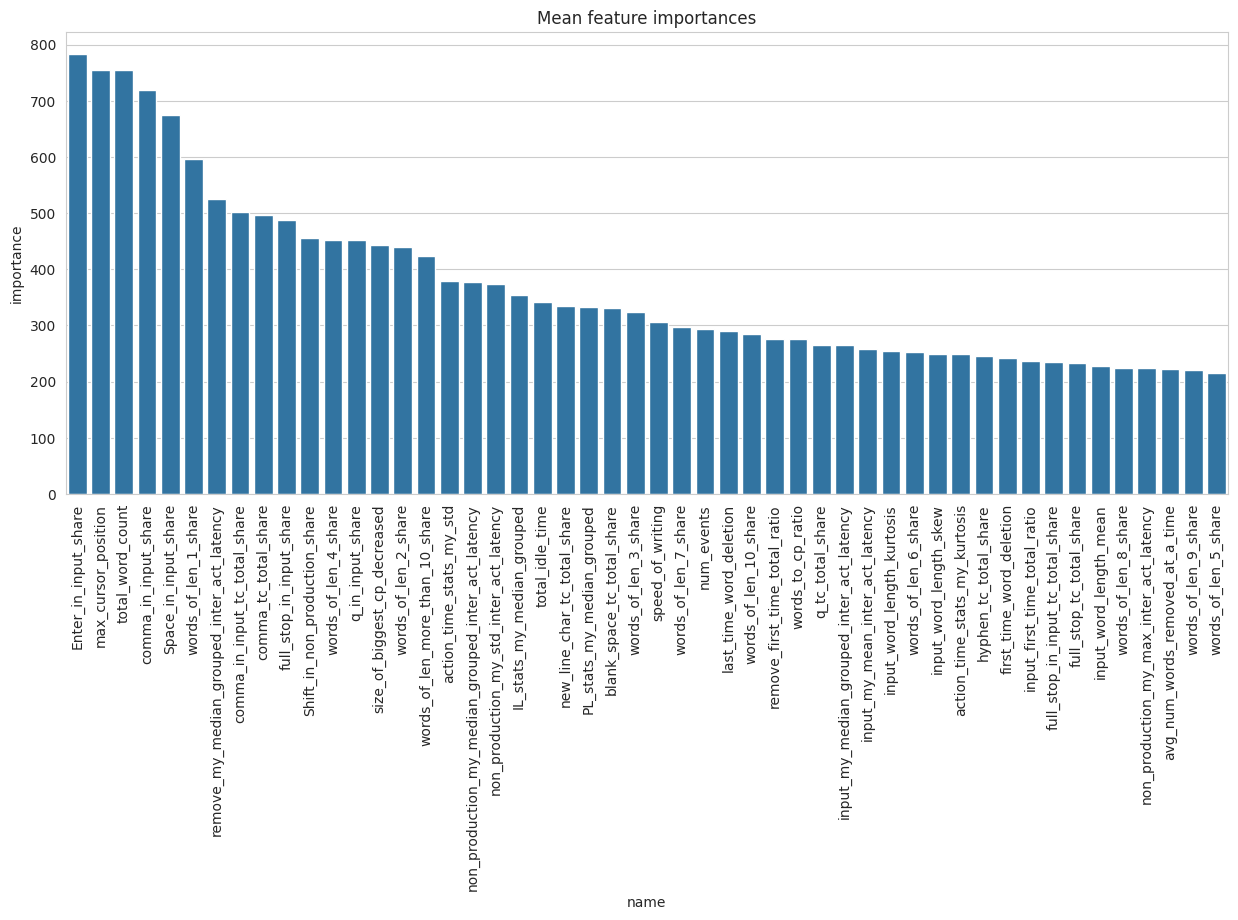

In [55]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df, x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Evaluation of OOF Preds on Training Set (CV)

In [56]:
for fold in range(cnfg.num_folds):
    print(f"Predicting the train set with FOLD {fold}")
    X_train = train_feats[train_feats["fold"] != fold][feature_names]
    Y_train = train_feats[train_feats["fold"] != fold][cnfg.response_variate]

    X_val = train_feats[train_feats["fold"] == fold][feature_names]
    Y_val = train_feats[train_feats["fold"] == fold][cnfg.response_variate]

    lgb_model = models_dict[fold]
    pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
    train_feats.loc[X_val.index, f"pred_{cnfg.response_variate}"] = pred_val

Predicting the train set with FOLD 0
Predicting the train set with FOLD 1
Predicting the train set with FOLD 2
Predicting the train set with FOLD 3
Predicting the train set with FOLD 4


In [57]:
rmse = mean_squared_error(
    train_feats[cnfg.response_variate],
    np.clip(train_feats[f"pred_{cnfg.response_variate}"], a_min=0.5, a_max=6.0),
    squared=False,
)
print("CV RMSE:", rmse)
train_feats = train_feats.drop(columns=["pred_score"])

CV RMSE: 0.6312505505937492


# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [58]:
for fold in range(cnfg.num_folds):
    print(f"Predicting the test set with FOLD {fold}")
    X_test = test_feats[feature_names]

    lgb_model = models_dict[fold]
    pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
    test_feats[f"pred_{cnfg.response_variate}_fold{fold}"] = pred

test_feats[cnfg.response_variate] = test_feats[
    [f"pred_{cnfg.response_variate}_fold{fold}" for fold in range(cnfg.num_folds)]
].mean(axis=1)
test_feats[cnfg.response_variate] = np.clip(
    test_feats[cnfg.response_variate], a_min=0.5, a_max=6.0
)

Predicting the test set with FOLD 0
Predicting the test set with FOLD 1
Predicting the test set with FOLD 2
Predicting the test set with FOLD 3
Predicting the test set with FOLD 4


# Submission

In [59]:
submission = test_feats[["id", cnfg.response_variate]]
submission

,id,score
0,0000aaaa,1.714799
1,2222bbbb,1.909268
2,4444cccc,1.792336


In [60]:
submission.to_csv("submission.csv", index=False)